# Use Case Replication
#### @author: Juan Rafael Caro Romero

This is the first task of the Module 5 ans consist in replicate the exercise do it in the Lesson 1 but with other criteria of analysis. In order to make a change in the task it has been decided to choose the OKCupid dataset.

In [1]:
#Import all the neccesary libraries
%matplotlib inline
%config InlineBackend.figure_format='svg'
from IPython.display import display,HTML
import pandas as pd
import seaborn as sns
from scipy.stats import kendalltau
import numpy as np
import math
import matplotlib.pyplot as plt

from prettypandas import PrettyPandas
sns.set(style="ticks")
sns.set_context(context="notebook",font_scale=1)

import string
import tqdm # a cool progress bar
import re
import json

import pymongo
from pymongo import MongoClient
from collections import Counter

In [2]:
#Load the data and show the number of rows and columns
okCupid = pd.read_csv('/home/master/Descargas/profiles.csv')
print(okCupid.shape)

(59946, 31)


The dataset isn't too big so it's no neccesary to reduce it. It's time to create a connection with Mongo and store the dataset.

In [3]:
#Configure and connection Mongo
print('Mongo version', pymongo.__version__)
client = MongoClient('localhost', 27017)
db = client.master
collection = db.okcupid

#Import data into the database
collection.drop()

Mongo version 3.9.0


In [4]:
# Transform dataframe to Json and store in MongoDB
records = json.loads(okCupid.to_json(orient='records'))
collection.delete_many({})
collection.insert_many(records)

In [5]:
cursor = collection.find().sort('sex',pymongo.ASCENDING).limit(1)
for doc in cursor:
    print(doc)

{'_id': ObjectId('5e2565494d3419d95a8b3b85'), 'age': 32, 'body_type': 'fit', 'diet': 'strictly anything', 'drinks': 'socially', 'drugs': 'never', 'education': 'graduated from college/university', 'essay0': "life is about the little things. i love to laugh. it's easy to do\nwhen one can find beauty and humor in the ugly. this perspective\nmakes for a more gratifying life. it's a gift. we are here to play.", 'essay1': 'digging up buried treasure', 'essay2': 'frolicking<br />\nwitty banter<br />\nusing my camera to extract sums of a whole and share my perspective\nwith the world in hopes of opening up theirs<br />\nbeing amused by things most people would miss', 'essay3': 'i am the last unicorn', 'essay4': "i like books. ones with pictures. reading them is great too. where\ndo people find the time? i spend more time with other people not\nreading. i collect books. they sit neatly on my bookshelves.<br />\n<br />\nmovies are great. especially on movie night. with brownies.<br />\n<br />\nm

With this view, it can be proved that in the data are some no alphanumeric characters. In the following steps it will be corrected, but now some visualizations.

## Visualization and prelinary analysis

In [6]:
# Plotting bargraph
def plotdat(data,cat,xl,yl,title,c):
    l=data.groupby(cat).size()
    l.sort_values(ascending=True).sort_index()
    fig=plt.figure(figsize=(10,5))
    fig.suptitle(title)
    plt.yticks(fontsize=8)
    l.plot(kind='bar',fontsize=12,color=c)
    plt.xlabel(xl)
    plt.ylabel(yl,fontsize=10)

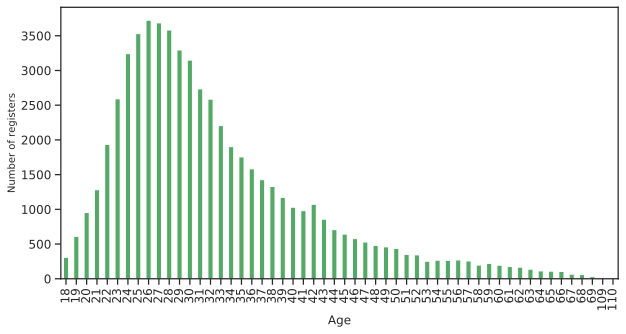

In [7]:
plotdat(okCupid,'age','Age','Number of registers','','g')

In [8]:
okCupid[okCupid['age'] > 69]

age body_type          diet drinks  drugs                   education  \
2512   110       NaN           NaN    NaN    NaN                         NaN   
25324  109  athletic  mostly other    NaN  never  working on masters program   

      essay0 essay1 essay2   essay3  ...                   location  \
2512     NaN    NaN    NaN      NaN  ...      daly city, california   
25324    NaN    NaN    NaN  nothing  ...  san francisco, california   

             offspring orientation pets                             religion  \
2512               NaN    straight  NaN                                  NaN   
25324  might want kids    straight  NaN  other and somewhat serious about it   

      sex                                  sign         smokes  \
2512    f                                   NaN            NaN   
25324   m  aquarius but it doesn&rsquo;t matter  when drinking   

               speaks     status  
2512          english     single  
25324  english (okay)  available  

[2 rows x 31 columns]

There are some outliers data so it will be deleted.

In [9]:
collection.delete_many({"age": {"$gt": 69}})

In [10]:
#Split data by age
pipeline = [
        {"$match": {"sex":"m"}},
]

aggResult = collection.aggregate(pipeline)
male = pd.DataFrame(list(aggResult))
male.head(2)

_id  age       body_type               diet    drinks  \
0  5e2565494d3419d95a8b3b7f   22  a little extra  strictly anything  socially   
1  5e2565494d3419d95a8b3b80   35         average       mostly other     often   

       drugs                      education  \
0      never  working on college/university   
1  sometimes          working on space camp   

                                              essay0  \
0  about me:<br />\n<br />\ni would love to think...   
1  i am a chef: this is what that means.<br />\n1...   

                                              essay1  \
0  currently working as an international agent fo...   
1  dedicating everyday to being an unbelievable b...   

                                              essay2  ...  \
0  making people laugh.<br />\nranting about a go...  ...   
1  being silly. having ridiculous amonts of fun w...  ...   

                          location  \
0  south san francisco, california   
1              oakland, california   

                                      offspring orientation  \
0  doesn&rsquo;t have kids, but might want them    straight   
1  doesn&rsquo;t have kids, but might want them    straight   

                        pets                                  religion sex  \
0  likes dogs and likes cats     agnosticism and very serious about it   m   
1  likes dogs and likes cats  agnosticism but not too serious about it   m   

     sign     smokes                                             speaks  \
0  gemini  sometimes                                            english   
1  cancer         no  english (fluently), spanish (poorly), french (...   

   status  
0  single  
1  single  

[2 rows x 32 columns]

In [11]:
pipeline = [
        {"$match": {"sex":"f"}},
]

aggResult = collection.aggregate(pipeline)
female = pd.DataFrame(list(aggResult))
female.head(2)

_id  age body_type               diet    drinks  \
0  5e2565494d3419d95a8b3b85   32       fit  strictly anything  socially   
1  5e2565494d3419d95a8b3b86   31   average    mostly anything  socially   

   drugs                          education  \
0  never  graduated from college/university   
1  never  graduated from college/university   

                                              essay0  \
0  life is about the little things. i love to lau...   
1                                               None   

                                              essay1  \
0                         digging up buried treasure   
1  writing. meeting new people, spending time wit...   

                                              essay2  ...  \
0  frolicking<br />\nwitty banter<br />\nusing my...  ...   
1  remembering people's birthdays, sending cards,...  ...   

                    location                                offspring  \
0  san francisco, california                                     None   
1  san francisco, california  doesn&rsquo;t have kids, but wants them   

  orientation                       pets      religion sex         sign  \
0    straight  likes dogs and likes cats          None   f        virgo   
1    straight  likes dogs and likes cats  christianity   f  sagittarius   

  smokes                   speaks  status  
0   None                  english  single  
1     no  english, spanish (okay)  single  

[2 rows x 32 columns]

In [12]:
print("Male registers: ", male.shape[0])
print("Female registers: ", female.shape[0])

Male registers:  35828
Female registers:  24116


It will be created a CSV file to store the new dataset.

In [13]:
#Save the correct data
aggResult = collection.find()
okCupid_correct = pd.DataFrame(list(aggResult))
print(okCupid_correct.shape)
okCupid_correct.to_csv('/home/master/Descargas/okCupid_correct_age.csv')

(59944, 32)


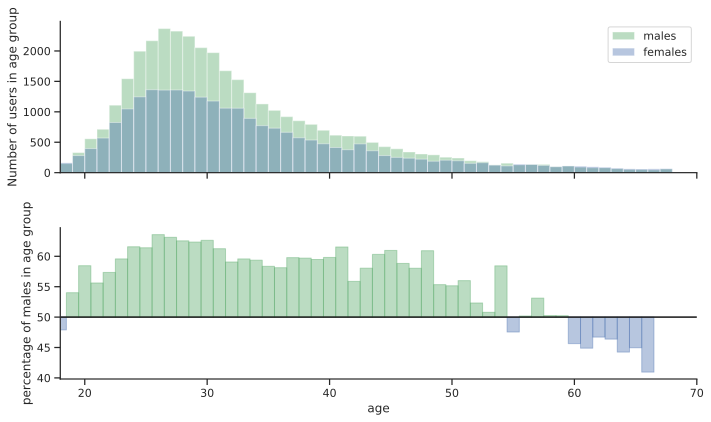

In [14]:
#Age comparation by sex

fig,(ax1,ax2) = plt.subplots(nrows=2,figsize=(10,6),sharex=True)
# Plot the age distributions of males and females on the same axis
sns.distplot(male["age"], ax=ax1,
             bins=range(okCupid_correct["age"].min(),okCupid_correct["age"].max()),
             kde=False,
             color="g",
             label="males")
sns.distplot(female["age"], ax=ax1,
             bins=range(okCupid_correct["age"].min(),okCupid_correct["age"].max()),
             kde=False,
             color="b",
             label="females")
ax1.set_ylabel("Number of users in age group")
ax1.set_xlabel("")
ax1.legend()

# Compute the fraction of males for every age value
fraction_of_males=(male["age"].value_counts()/okCupid_correct["age"].value_counts())
# Ignore values computed from age groups in which we have less than 100 total users (else estimates are too unstable)
fraction_of_males[okCupid_correct["age"].value_counts()<100]=None
barlist=ax2.bar(x=fraction_of_males.index,
        height=fraction_of_males*100-50,
        bottom=50, width=1, color="gray")
for bar,frac in zip(barlist,fraction_of_males):
    bar.set_color("g" if frac>.5 else "b")
    bar.set_alpha(0.4)
ax2.set_xlim([18,70])
ax2.set_xlabel("age")
ax2.set_ylabel("percentage of males in age group")
ax2.axhline(y=50,color="k")

for ax in (ax1,ax2):
    sns.despine(ax=ax)
fig.tight_layout()

It can be done a preliminary analysis with the 'age', 'orientation' and 'sex'. The next step is to set a classification for the range of age and create a new column: 
  - Age range 1: 18-24
  - Age range 2: 25-33
  - Age range 3: 34-44
  - Age range 4: 45-55
  - Age range 5: 56-61
  - Age range 6: 62-69
  
In order to simplify the next conditions, it has been created three new columns 'orientation_val', 'sex_val' and 'age_range' with a numerical value.
  - Straight: 1
  - Gay: 2
  - Bisexual: 3
  
  
  
  - Male: 0
  - Female: 1

In [15]:
#Create new column and convert the data to integer
#okCupid_correct = pd.read_csv('/home/master/Escritorio/mdcasousoi/okCupid_correct_age.csv', index_col=0)
age_range = []
orientation_sel = []
sex_sel = []

for a in okCupid_correct['age']:
    if((a >= 18) & (a <= 24)):
        age_range.append(1)
    elif((a >= 25) & (a <= 33)):
        age_range.append(2)
    elif((a >= 34) & (a <= 44)):
        age_range.append(3)
    elif((a >= 45) & (a <= 55)):
        age_range.append(4)
    elif((a >= 56) & (a <= 61)):
        age_range.append(5)
    elif((a >= 62) & (a <= 69)):
        age_range.append(6)
        
for i in okCupid_correct['orientation']:
    if(i == 'straight'):
        orientation_sel.append(1)
    elif (i == 'gay'):
        orientation_sel.append(2)
    elif (i == 'bisexual'):
        orientation_sel.append(3)
        
for j in okCupid_correct['sex']:
    if(j == 'f'):
        sex_sel.append(0)
    elif (j == 'm'):
        sex_sel.append(1)
        
okCupid_correct['age_range'] = age_range
okCupid_correct['orientation_val'] = orientation_sel
okCupid_correct['sex_val'] = sex_sel
okCupid_correct.head(2)

_id  age       body_type               diet    drinks  \
0  5e2565494d3419d95a8b3b7f   22  a little extra  strictly anything  socially   
1  5e2565494d3419d95a8b3b80   35         average       mostly other     often   

       drugs                      education  \
0      never  working on college/university   
1  sometimes          working on space camp   

                                              essay0  \
0  about me:<br />\n<br />\ni would love to think...   
1  i am a chef: this is what that means.<br />\n1...   

                                              essay1  \
0  currently working as an international agent fo...   
1  dedicating everyday to being an unbelievable b...   

                                              essay2  ...  \
0  making people laugh.<br />\nranting about a go...  ...   
1  being silly. having ridiculous amonts of fun w...  ...   

                        pets                                  religion sex  \
0  likes dogs and likes cats     agnosticism and very serious about it   m   
1  likes dogs and likes cats  agnosticism but not too serious about it   m   

     sign     smokes                                             speaks  \
0  gemini  sometimes                                            english   
1  cancer         no  english (fluently), spanish (poorly), french (...   

   status age_range  orientation_val  sex_val  
0  single         1                1        1  
1  single         3                1        1  

[2 rows x 35 columns]

Given the data above it can be possible to create a function that randomly select a couple of person of the same range age and orientation for a preliminary analysis. This function will be created in future steps.

## Data cleaning

The data can be cleaned eliminating the rows with a lot of NaN (more than 5), deleting the no alphanumberic data...

In [16]:
nan_index = []
for i in range(len(okCupid_correct.index)) :
    if(okCupid_correct.iloc[i].isna().sum() > 5):
        print("Nan in row is greater than 5", i , " : " ,  okCupid_correct.iloc[i].isna().sum())
        nan_index.append(i)

Nan in row is greater than 5 2  :  6
Nan in row is greater than 5 4  :  8
Nan in row is greater than 5 8  :  6
Nan in row is greater than 5 10  :  6
Nan in row is greater than 5 12  :  15
Nan in row is greater than 5 13  :  12
Nan in row is greater than 5 21  :  6
Nan in row is greater than 5 28  :  6
Nan in row is greater than 5 29  :  6
Nan in row is greater than 5 30  :  9
Nan in row is greater than 5 32  :  7
Nan in row is greater than 5 34  :  6
Nan in row is greater than 5 35  :  16
Nan in row is greater than 5 38  :  8
Nan in row is greater than 5 39  :  6
Nan in row is greater than 5 41  :  8
Nan in row is greater than 5 42  :  8
Nan in row is greater than 5 46  :  17
Nan in row is greater than 5 47  :  6
Nan in row is greater than 5 49  :  9
Nan in row is greater than 5 51  :  13
Nan in row is greater than 5 53  :  15
Nan in row is greater than 5 54  :  8
Nan in row is greater than 5 57  :  6
Nan in row is greater than 5 58  :  10
Nan in row is greater than 5 64  :  12
Nan in 

Nan in row is greater than 5 796  :  9
Nan in row is greater than 5 797  :  6
Nan in row is greater than 5 803  :  19
Nan in row is greater than 5 812  :  10
Nan in row is greater than 5 816  :  6
Nan in row is greater than 5 817  :  8
Nan in row is greater than 5 819  :  7
Nan in row is greater than 5 820  :  16
Nan in row is greater than 5 822  :  10
Nan in row is greater than 5 823  :  8
Nan in row is greater than 5 827  :  10
Nan in row is greater than 5 828  :  10
Nan in row is greater than 5 832  :  8
Nan in row is greater than 5 833  :  7
Nan in row is greater than 5 834  :  9
Nan in row is greater than 5 842  :  9
Nan in row is greater than 5 843  :  13
Nan in row is greater than 5 847  :  7
Nan in row is greater than 5 851  :  14
Nan in row is greater than 5 854  :  9
Nan in row is greater than 5 856  :  9
Nan in row is greater than 5 865  :  7
Nan in row is greater than 5 871  :  7
Nan in row is greater than 5 873  :  9
Nan in row is greater than 5 874  :  12
Nan in row is gr

Nan in row is greater than 5 1595  :  9
Nan in row is greater than 5 1596  :  8
Nan in row is greater than 5 1601  :  7
Nan in row is greater than 5 1605  :  9
Nan in row is greater than 5 1607  :  6
Nan in row is greater than 5 1611  :  6
Nan in row is greater than 5 1617  :  8
Nan in row is greater than 5 1623  :  7
Nan in row is greater than 5 1625  :  6
Nan in row is greater than 5 1626  :  14
Nan in row is greater than 5 1629  :  6
Nan in row is greater than 5 1630  :  8
Nan in row is greater than 5 1633  :  9
Nan in row is greater than 5 1637  :  6
Nan in row is greater than 5 1641  :  8
Nan in row is greater than 5 1643  :  7
Nan in row is greater than 5 1644  :  6
Nan in row is greater than 5 1646  :  11
Nan in row is greater than 5 1647  :  6
Nan in row is greater than 5 1648  :  10
Nan in row is greater than 5 1651  :  9
Nan in row is greater than 5 1652  :  8
Nan in row is greater than 5 1654  :  8
Nan in row is greater than 5 1657  :  6
Nan in row is greater than 5 1662  : 

Nan in row is greater than 5 2315  :  14
Nan in row is greater than 5 2317  :  6
Nan in row is greater than 5 2319  :  13
Nan in row is greater than 5 2326  :  7
Nan in row is greater than 5 2327  :  9
Nan in row is greater than 5 2332  :  7
Nan in row is greater than 5 2333  :  12
Nan in row is greater than 5 2334  :  7
Nan in row is greater than 5 2335  :  11
Nan in row is greater than 5 2337  :  12
Nan in row is greater than 5 2340  :  7
Nan in row is greater than 5 2341  :  10
Nan in row is greater than 5 2347  :  17
Nan in row is greater than 5 2350  :  7
Nan in row is greater than 5 2351  :  8
Nan in row is greater than 5 2352  :  7
Nan in row is greater than 5 2355  :  6
Nan in row is greater than 5 2358  :  8
Nan in row is greater than 5 2359  :  6
Nan in row is greater than 5 2361  :  13
Nan in row is greater than 5 2363  :  9
Nan in row is greater than 5 2364  :  7
Nan in row is greater than 5 2367  :  13
Nan in row is greater than 5 2368  :  9
Nan in row is greater than 5 23

Nan in row is greater than 5 2946  :  16
Nan in row is greater than 5 2948  :  7
Nan in row is greater than 5 2950  :  8
Nan in row is greater than 5 2951  :  9
Nan in row is greater than 5 2954  :  11
Nan in row is greater than 5 2956  :  11
Nan in row is greater than 5 2958  :  7
Nan in row is greater than 5 2970  :  9
Nan in row is greater than 5 2972  :  10
Nan in row is greater than 5 2973  :  8
Nan in row is greater than 5 2986  :  13
Nan in row is greater than 5 2989  :  8
Nan in row is greater than 5 2991  :  9
Nan in row is greater than 5 2992  :  6
Nan in row is greater than 5 2998  :  6
Nan in row is greater than 5 2999  :  7
Nan in row is greater than 5 3002  :  9
Nan in row is greater than 5 3004  :  13
Nan in row is greater than 5 3006  :  7
Nan in row is greater than 5 3020  :  9
Nan in row is greater than 5 3021  :  7
Nan in row is greater than 5 3023  :  18
Nan in row is greater than 5 3024  :  12
Nan in row is greater than 5 3027  :  6
Nan in row is greater than 5 302

Nan in row is greater than 5 3661  :  13
Nan in row is greater than 5 3669  :  11
Nan in row is greater than 5 3674  :  11
Nan in row is greater than 5 3675  :  6
Nan in row is greater than 5 3679  :  14
Nan in row is greater than 5 3680  :  9
Nan in row is greater than 5 3681  :  11
Nan in row is greater than 5 3684  :  12
Nan in row is greater than 5 3685  :  15
Nan in row is greater than 5 3686  :  6
Nan in row is greater than 5 3697  :  7
Nan in row is greater than 5 3702  :  6
Nan in row is greater than 5 3703  :  6
Nan in row is greater than 5 3709  :  8
Nan in row is greater than 5 3711  :  13
Nan in row is greater than 5 3712  :  8
Nan in row is greater than 5 3715  :  7
Nan in row is greater than 5 3716  :  6
Nan in row is greater than 5 3725  :  8
Nan in row is greater than 5 3726  :  9
Nan in row is greater than 5 3727  :  6
Nan in row is greater than 5 3728  :  7
Nan in row is greater than 5 3733  :  6
Nan in row is greater than 5 3749  :  7
Nan in row is greater than 5 375

Nan in row is greater than 5 4420  :  14
Nan in row is greater than 5 4421  :  9
Nan in row is greater than 5 4423  :  9
Nan in row is greater than 5 4426  :  13
Nan in row is greater than 5 4427  :  10
Nan in row is greater than 5 4428  :  9
Nan in row is greater than 5 4432  :  6
Nan in row is greater than 5 4433  :  9
Nan in row is greater than 5 4435  :  10
Nan in row is greater than 5 4436  :  6
Nan in row is greater than 5 4437  :  8
Nan in row is greater than 5 4442  :  10
Nan in row is greater than 5 4443  :  6
Nan in row is greater than 5 4455  :  13
Nan in row is greater than 5 4456  :  12
Nan in row is greater than 5 4459  :  6
Nan in row is greater than 5 4460  :  10
Nan in row is greater than 5 4464  :  9
Nan in row is greater than 5 4468  :  7
Nan in row is greater than 5 4469  :  6
Nan in row is greater than 5 4475  :  14
Nan in row is greater than 5 4476  :  10
Nan in row is greater than 5 4488  :  6
Nan in row is greater than 5 4494  :  18
Nan in row is greater than 5 

Nan in row is greater than 5 5122  :  12
Nan in row is greater than 5 5124  :  9
Nan in row is greater than 5 5125  :  6
Nan in row is greater than 5 5127  :  8
Nan in row is greater than 5 5130  :  11
Nan in row is greater than 5 5133  :  13
Nan in row is greater than 5 5134  :  14
Nan in row is greater than 5 5137  :  7
Nan in row is greater than 5 5139  :  12
Nan in row is greater than 5 5140  :  6
Nan in row is greater than 5 5143  :  8
Nan in row is greater than 5 5146  :  8
Nan in row is greater than 5 5155  :  13
Nan in row is greater than 5 5159  :  6
Nan in row is greater than 5 5162  :  6
Nan in row is greater than 5 5165  :  7
Nan in row is greater than 5 5167  :  11
Nan in row is greater than 5 5173  :  7
Nan in row is greater than 5 5180  :  12
Nan in row is greater than 5 5181  :  12
Nan in row is greater than 5 5183  :  8
Nan in row is greater than 5 5187  :  17
Nan in row is greater than 5 5195  :  7
Nan in row is greater than 5 5197  :  7
Nan in row is greater than 5 5

Nan in row is greater than 5 5956  :  12
Nan in row is greater than 5 5960  :  11
Nan in row is greater than 5 5963  :  7
Nan in row is greater than 5 5967  :  10
Nan in row is greater than 5 5972  :  8
Nan in row is greater than 5 5974  :  17
Nan in row is greater than 5 5984  :  13
Nan in row is greater than 5 5990  :  7
Nan in row is greater than 5 5995  :  6
Nan in row is greater than 5 6003  :  18
Nan in row is greater than 5 6009  :  10
Nan in row is greater than 5 6013  :  12
Nan in row is greater than 5 6014  :  9
Nan in row is greater than 5 6016  :  6
Nan in row is greater than 5 6021  :  20
Nan in row is greater than 5 6022  :  7
Nan in row is greater than 5 6024  :  16
Nan in row is greater than 5 6030  :  7
Nan in row is greater than 5 6033  :  14
Nan in row is greater than 5 6038  :  8
Nan in row is greater than 5 6043  :  15
Nan in row is greater than 5 6057  :  12
Nan in row is greater than 5 6059  :  8
Nan in row is greater than 5 6062  :  9
Nan in row is greater than 

Nan in row is greater than 5 6795  :  12
Nan in row is greater than 5 6801  :  9
Nan in row is greater than 5 6807  :  6
Nan in row is greater than 5 6812  :  6
Nan in row is greater than 5 6817  :  11
Nan in row is greater than 5 6819  :  7
Nan in row is greater than 5 6822  :  6
Nan in row is greater than 5 6827  :  6
Nan in row is greater than 5 6828  :  12
Nan in row is greater than 5 6829  :  13
Nan in row is greater than 5 6831  :  15
Nan in row is greater than 5 6834  :  8
Nan in row is greater than 5 6839  :  9
Nan in row is greater than 5 6846  :  8
Nan in row is greater than 5 6851  :  16
Nan in row is greater than 5 6859  :  11
Nan in row is greater than 5 6860  :  13
Nan in row is greater than 5 6864  :  19
Nan in row is greater than 5 6868  :  7
Nan in row is greater than 5 6869  :  14
Nan in row is greater than 5 6872  :  7
Nan in row is greater than 5 6876  :  11
Nan in row is greater than 5 6881  :  10
Nan in row is greater than 5 6887  :  12
Nan in row is greater than 

Nan in row is greater than 5 7543  :  9
Nan in row is greater than 5 7557  :  15
Nan in row is greater than 5 7559  :  11
Nan in row is greater than 5 7560  :  11
Nan in row is greater than 5 7567  :  9
Nan in row is greater than 5 7570  :  9
Nan in row is greater than 5 7571  :  9
Nan in row is greater than 5 7573  :  12
Nan in row is greater than 5 7583  :  11
Nan in row is greater than 5 7593  :  13
Nan in row is greater than 5 7596  :  15
Nan in row is greater than 5 7599  :  10
Nan in row is greater than 5 7601  :  10
Nan in row is greater than 5 7603  :  6
Nan in row is greater than 5 7605  :  13
Nan in row is greater than 5 7606  :  8
Nan in row is greater than 5 7609  :  13
Nan in row is greater than 5 7610  :  6
Nan in row is greater than 5 7616  :  6
Nan in row is greater than 5 7624  :  6
Nan in row is greater than 5 7625  :  9
Nan in row is greater than 5 7632  :  7
Nan in row is greater than 5 7638  :  7
Nan in row is greater than 5 7640  :  7
Nan in row is greater than 5 

Nan in row is greater than 5 8338  :  6
Nan in row is greater than 5 8339  :  16
Nan in row is greater than 5 8349  :  6
Nan in row is greater than 5 8350  :  10
Nan in row is greater than 5 8351  :  8
Nan in row is greater than 5 8353  :  12
Nan in row is greater than 5 8363  :  8
Nan in row is greater than 5 8365  :  10
Nan in row is greater than 5 8366  :  6
Nan in row is greater than 5 8369  :  7
Nan in row is greater than 5 8372  :  13
Nan in row is greater than 5 8374  :  11
Nan in row is greater than 5 8377  :  9
Nan in row is greater than 5 8385  :  8
Nan in row is greater than 5 8388  :  6
Nan in row is greater than 5 8390  :  15
Nan in row is greater than 5 8392  :  7
Nan in row is greater than 5 8394  :  8
Nan in row is greater than 5 8395  :  7
Nan in row is greater than 5 8399  :  11
Nan in row is greater than 5 8401  :  7
Nan in row is greater than 5 8405  :  6
Nan in row is greater than 5 8408  :  6
Nan in row is greater than 5 8409  :  12
Nan in row is greater than 5 84

Nan in row is greater than 5 9137  :  10
Nan in row is greater than 5 9138  :  6
Nan in row is greater than 5 9139  :  8
Nan in row is greater than 5 9143  :  8
Nan in row is greater than 5 9144  :  15
Nan in row is greater than 5 9150  :  7
Nan in row is greater than 5 9151  :  12
Nan in row is greater than 5 9152  :  8
Nan in row is greater than 5 9157  :  14
Nan in row is greater than 5 9161  :  6
Nan in row is greater than 5 9164  :  8
Nan in row is greater than 5 9166  :  7
Nan in row is greater than 5 9174  :  6
Nan in row is greater than 5 9176  :  7
Nan in row is greater than 5 9178  :  9
Nan in row is greater than 5 9179  :  9
Nan in row is greater than 5 9189  :  10
Nan in row is greater than 5 9191  :  11
Nan in row is greater than 5 9194  :  6
Nan in row is greater than 5 9195  :  19
Nan in row is greater than 5 9197  :  12
Nan in row is greater than 5 9204  :  6
Nan in row is greater than 5 9205  :  6
Nan in row is greater than 5 9206  :  14
Nan in row is greater than 5 92

Nan in row is greater than 5 9948  :  9
Nan in row is greater than 5 9950  :  13
Nan in row is greater than 5 9954  :  8
Nan in row is greater than 5 9956  :  11
Nan in row is greater than 5 9958  :  6
Nan in row is greater than 5 9960  :  13
Nan in row is greater than 5 9963  :  14
Nan in row is greater than 5 9965  :  11
Nan in row is greater than 5 9966  :  14
Nan in row is greater than 5 9967  :  11
Nan in row is greater than 5 9971  :  8
Nan in row is greater than 5 9973  :  7
Nan in row is greater than 5 9974  :  16
Nan in row is greater than 5 9978  :  6
Nan in row is greater than 5 9980  :  7
Nan in row is greater than 5 9981  :  6
Nan in row is greater than 5 9985  :  7
Nan in row is greater than 5 9988  :  6
Nan in row is greater than 5 9990  :  9
Nan in row is greater than 5 9993  :  15
Nan in row is greater than 5 9995  :  13
Nan in row is greater than 5 9996  :  9
Nan in row is greater than 5 9998  :  10
Nan in row is greater than 5 10000  :  7
Nan in row is greater than 5

Nan in row is greater than 5 10681  :  12
Nan in row is greater than 5 10688  :  7
Nan in row is greater than 5 10689  :  13
Nan in row is greater than 5 10690  :  6
Nan in row is greater than 5 10694  :  9
Nan in row is greater than 5 10695  :  7
Nan in row is greater than 5 10697  :  11
Nan in row is greater than 5 10700  :  10
Nan in row is greater than 5 10702  :  7
Nan in row is greater than 5 10703  :  6
Nan in row is greater than 5 10709  :  10
Nan in row is greater than 5 10711  :  7
Nan in row is greater than 5 10712  :  7
Nan in row is greater than 5 10713  :  9
Nan in row is greater than 5 10716  :  6
Nan in row is greater than 5 10722  :  7
Nan in row is greater than 5 10723  :  14
Nan in row is greater than 5 10725  :  11
Nan in row is greater than 5 10726  :  10
Nan in row is greater than 5 10727  :  8
Nan in row is greater than 5 10734  :  9
Nan in row is greater than 5 10740  :  15
Nan in row is greater than 5 10741  :  10
Nan in row is greater than 5 10742  :  8
Nan in

Nan in row is greater than 5 11435  :  6
Nan in row is greater than 5 11439  :  9
Nan in row is greater than 5 11447  :  13
Nan in row is greater than 5 11464  :  8
Nan in row is greater than 5 11468  :  10
Nan in row is greater than 5 11469  :  10
Nan in row is greater than 5 11472  :  7
Nan in row is greater than 5 11474  :  7
Nan in row is greater than 5 11477  :  7
Nan in row is greater than 5 11480  :  6
Nan in row is greater than 5 11481  :  7
Nan in row is greater than 5 11484  :  7
Nan in row is greater than 5 11486  :  15
Nan in row is greater than 5 11489  :  9
Nan in row is greater than 5 11494  :  7
Nan in row is greater than 5 11499  :  8
Nan in row is greater than 5 11500  :  6
Nan in row is greater than 5 11501  :  7
Nan in row is greater than 5 11502  :  6
Nan in row is greater than 5 11507  :  9
Nan in row is greater than 5 11510  :  7
Nan in row is greater than 5 11512  :  13
Nan in row is greater than 5 11515  :  9
Nan in row is greater than 5 11519  :  8
Nan in row 

Nan in row is greater than 5 12264  :  8
Nan in row is greater than 5 12265  :  11
Nan in row is greater than 5 12272  :  16
Nan in row is greater than 5 12274  :  18
Nan in row is greater than 5 12275  :  8
Nan in row is greater than 5 12280  :  7
Nan in row is greater than 5 12281  :  13
Nan in row is greater than 5 12289  :  7
Nan in row is greater than 5 12295  :  7
Nan in row is greater than 5 12301  :  6
Nan in row is greater than 5 12302  :  6
Nan in row is greater than 5 12305  :  15
Nan in row is greater than 5 12306  :  11
Nan in row is greater than 5 12308  :  20
Nan in row is greater than 5 12309  :  9
Nan in row is greater than 5 12327  :  9
Nan in row is greater than 5 12329  :  7
Nan in row is greater than 5 12330  :  7
Nan in row is greater than 5 12333  :  6
Nan in row is greater than 5 12334  :  7
Nan in row is greater than 5 12338  :  6
Nan in row is greater than 5 12345  :  9
Nan in row is greater than 5 12348  :  7
Nan in row is greater than 5 12353  :  6
Nan in ro

Nan in row is greater than 5 13172  :  6
Nan in row is greater than 5 13173  :  10
Nan in row is greater than 5 13175  :  17
Nan in row is greater than 5 13176  :  16
Nan in row is greater than 5 13179  :  7
Nan in row is greater than 5 13192  :  16
Nan in row is greater than 5 13194  :  10
Nan in row is greater than 5 13198  :  6
Nan in row is greater than 5 13199  :  7
Nan in row is greater than 5 13200  :  11
Nan in row is greater than 5 13203  :  9
Nan in row is greater than 5 13204  :  9
Nan in row is greater than 5 13205  :  17
Nan in row is greater than 5 13208  :  14
Nan in row is greater than 5 13212  :  7
Nan in row is greater than 5 13220  :  7
Nan in row is greater than 5 13228  :  11
Nan in row is greater than 5 13232  :  14
Nan in row is greater than 5 13235  :  11
Nan in row is greater than 5 13239  :  10
Nan in row is greater than 5 13242  :  10
Nan in row is greater than 5 13243  :  6
Nan in row is greater than 5 13245  :  9
Nan in row is greater than 5 13253  :  6
Nan

Nan in row is greater than 5 13859  :  7
Nan in row is greater than 5 13860  :  7
Nan in row is greater than 5 13863  :  13
Nan in row is greater than 5 13865  :  6
Nan in row is greater than 5 13866  :  10
Nan in row is greater than 5 13869  :  6
Nan in row is greater than 5 13871  :  7
Nan in row is greater than 5 13875  :  13
Nan in row is greater than 5 13878  :  6
Nan in row is greater than 5 13880  :  11
Nan in row is greater than 5 13881  :  12
Nan in row is greater than 5 13885  :  11
Nan in row is greater than 5 13887  :  7
Nan in row is greater than 5 13889  :  8
Nan in row is greater than 5 13890  :  6
Nan in row is greater than 5 13893  :  7
Nan in row is greater than 5 13896  :  10
Nan in row is greater than 5 13900  :  7
Nan in row is greater than 5 13901  :  8
Nan in row is greater than 5 13904  :  7
Nan in row is greater than 5 13905  :  8
Nan in row is greater than 5 13913  :  14
Nan in row is greater than 5 13915  :  10
Nan in row is greater than 5 13919  :  9
Nan in 

Nan in row is greater than 5 14858  :  6
Nan in row is greater than 5 14859  :  7
Nan in row is greater than 5 14864  :  6
Nan in row is greater than 5 14865  :  12
Nan in row is greater than 5 14866  :  13
Nan in row is greater than 5 14868  :  7
Nan in row is greater than 5 14879  :  7
Nan in row is greater than 5 14885  :  8
Nan in row is greater than 5 14886  :  15
Nan in row is greater than 5 14887  :  11
Nan in row is greater than 5 14892  :  6
Nan in row is greater than 5 14895  :  8
Nan in row is greater than 5 14905  :  6
Nan in row is greater than 5 14909  :  10
Nan in row is greater than 5 14922  :  7
Nan in row is greater than 5 14926  :  9
Nan in row is greater than 5 14927  :  14
Nan in row is greater than 5 14930  :  10
Nan in row is greater than 5 14931  :  11
Nan in row is greater than 5 14932  :  6
Nan in row is greater than 5 14933  :  10
Nan in row is greater than 5 14934  :  13
Nan in row is greater than 5 14938  :  8
Nan in row is greater than 5 14939  :  7
Nan in

Nan in row is greater than 5 15553  :  11
Nan in row is greater than 5 15557  :  19
Nan in row is greater than 5 15558  :  12
Nan in row is greater than 5 15561  :  9
Nan in row is greater than 5 15565  :  6
Nan in row is greater than 5 15569  :  12
Nan in row is greater than 5 15570  :  6
Nan in row is greater than 5 15572  :  13
Nan in row is greater than 5 15576  :  6
Nan in row is greater than 5 15577  :  13
Nan in row is greater than 5 15580  :  6
Nan in row is greater than 5 15583  :  11
Nan in row is greater than 5 15584  :  7
Nan in row is greater than 5 15587  :  6
Nan in row is greater than 5 15589  :  15
Nan in row is greater than 5 15590  :  6
Nan in row is greater than 5 15593  :  12
Nan in row is greater than 5 15602  :  14
Nan in row is greater than 5 15610  :  11
Nan in row is greater than 5 15612  :  10
Nan in row is greater than 5 15618  :  6
Nan in row is greater than 5 15625  :  8
Nan in row is greater than 5 15626  :  6
Nan in row is greater than 5 15635  :  6
Nan 

Nan in row is greater than 5 16304  :  18
Nan in row is greater than 5 16308  :  12
Nan in row is greater than 5 16309  :  11
Nan in row is greater than 5 16314  :  6
Nan in row is greater than 5 16317  :  6
Nan in row is greater than 5 16321  :  9
Nan in row is greater than 5 16325  :  11
Nan in row is greater than 5 16326  :  10
Nan in row is greater than 5 16328  :  10
Nan in row is greater than 5 16337  :  7
Nan in row is greater than 5 16338  :  10
Nan in row is greater than 5 16339  :  11
Nan in row is greater than 5 16341  :  8
Nan in row is greater than 5 16353  :  10
Nan in row is greater than 5 16362  :  14
Nan in row is greater than 5 16366  :  10
Nan in row is greater than 5 16367  :  7
Nan in row is greater than 5 16369  :  6
Nan in row is greater than 5 16370  :  7
Nan in row is greater than 5 16375  :  13
Nan in row is greater than 5 16376  :  6
Nan in row is greater than 5 16378  :  11
Nan in row is greater than 5 16379  :  18
Nan in row is greater than 5 16382  :  6
Na

Nan in row is greater than 5 16956  :  7
Nan in row is greater than 5 16959  :  10
Nan in row is greater than 5 16965  :  11
Nan in row is greater than 5 16966  :  10
Nan in row is greater than 5 16971  :  10
Nan in row is greater than 5 16973  :  7
Nan in row is greater than 5 16975  :  6
Nan in row is greater than 5 16977  :  10
Nan in row is greater than 5 16978  :  9
Nan in row is greater than 5 16981  :  11
Nan in row is greater than 5 16982  :  11
Nan in row is greater than 5 16983  :  9
Nan in row is greater than 5 16995  :  7
Nan in row is greater than 5 16999  :  6
Nan in row is greater than 5 17003  :  7
Nan in row is greater than 5 17005  :  6
Nan in row is greater than 5 17016  :  6
Nan in row is greater than 5 17022  :  9
Nan in row is greater than 5 17028  :  10
Nan in row is greater than 5 17029  :  13
Nan in row is greater than 5 17043  :  9
Nan in row is greater than 5 17045  :  7
Nan in row is greater than 5 17047  :  11
Nan in row is greater than 5 17053  :  13
Nan i

Nan in row is greater than 5 17792  :  8
Nan in row is greater than 5 17794  :  11
Nan in row is greater than 5 17795  :  7
Nan in row is greater than 5 17806  :  14
Nan in row is greater than 5 17807  :  7
Nan in row is greater than 5 17810  :  6
Nan in row is greater than 5 17813  :  6
Nan in row is greater than 5 17819  :  6
Nan in row is greater than 5 17820  :  11
Nan in row is greater than 5 17821  :  6
Nan in row is greater than 5 17822  :  10
Nan in row is greater than 5 17823  :  16
Nan in row is greater than 5 17825  :  8
Nan in row is greater than 5 17826  :  13
Nan in row is greater than 5 17827  :  19
Nan in row is greater than 5 17828  :  11
Nan in row is greater than 5 17830  :  10
Nan in row is greater than 5 17835  :  15
Nan in row is greater than 5 17836  :  12
Nan in row is greater than 5 17837  :  11
Nan in row is greater than 5 17840  :  6
Nan in row is greater than 5 17843  :  8
Nan in row is greater than 5 17848  :  11
Nan in row is greater than 5 17853  :  13
Na

Nan in row is greater than 5 18458  :  14
Nan in row is greater than 5 18460  :  17
Nan in row is greater than 5 18464  :  10
Nan in row is greater than 5 18476  :  8
Nan in row is greater than 5 18479  :  12
Nan in row is greater than 5 18483  :  7
Nan in row is greater than 5 18506  :  6
Nan in row is greater than 5 18507  :  13
Nan in row is greater than 5 18513  :  6
Nan in row is greater than 5 18528  :  15
Nan in row is greater than 5 18529  :  15
Nan in row is greater than 5 18535  :  10
Nan in row is greater than 5 18536  :  12
Nan in row is greater than 5 18540  :  11
Nan in row is greater than 5 18547  :  7
Nan in row is greater than 5 18549  :  7
Nan in row is greater than 5 18550  :  8
Nan in row is greater than 5 18562  :  11
Nan in row is greater than 5 18563  :  7
Nan in row is greater than 5 18574  :  7
Nan in row is greater than 5 18576  :  8
Nan in row is greater than 5 18581  :  18
Nan in row is greater than 5 18586  :  11
Nan in row is greater than 5 18591  :  8
Nan

Nan in row is greater than 5 19438  :  7
Nan in row is greater than 5 19441  :  10
Nan in row is greater than 5 19443  :  7
Nan in row is greater than 5 19447  :  12
Nan in row is greater than 5 19449  :  7
Nan in row is greater than 5 19453  :  13
Nan in row is greater than 5 19458  :  6
Nan in row is greater than 5 19462  :  17
Nan in row is greater than 5 19463  :  6
Nan in row is greater than 5 19466  :  6
Nan in row is greater than 5 19468  :  12
Nan in row is greater than 5 19470  :  8
Nan in row is greater than 5 19473  :  12
Nan in row is greater than 5 19474  :  6
Nan in row is greater than 5 19475  :  12
Nan in row is greater than 5 19476  :  15
Nan in row is greater than 5 19482  :  9
Nan in row is greater than 5 19485  :  8
Nan in row is greater than 5 19486  :  7
Nan in row is greater than 5 19488  :  7
Nan in row is greater than 5 19489  :  13
Nan in row is greater than 5 19490  :  7
Nan in row is greater than 5 19492  :  7
Nan in row is greater than 5 19494  :  17
Nan in

Nan in row is greater than 5 20251  :  6
Nan in row is greater than 5 20255  :  7
Nan in row is greater than 5 20258  :  6
Nan in row is greater than 5 20260  :  7
Nan in row is greater than 5 20266  :  9
Nan in row is greater than 5 20268  :  6
Nan in row is greater than 5 20269  :  12
Nan in row is greater than 5 20271  :  13
Nan in row is greater than 5 20274  :  10
Nan in row is greater than 5 20278  :  6
Nan in row is greater than 5 20279  :  11
Nan in row is greater than 5 20281  :  6
Nan in row is greater than 5 20283  :  6
Nan in row is greater than 5 20285  :  8
Nan in row is greater than 5 20286  :  6
Nan in row is greater than 5 20287  :  6
Nan in row is greater than 5 20290  :  12
Nan in row is greater than 5 20294  :  11
Nan in row is greater than 5 20298  :  16
Nan in row is greater than 5 20304  :  8
Nan in row is greater than 5 20305  :  10
Nan in row is greater than 5 20311  :  7
Nan in row is greater than 5 20313  :  12
Nan in row is greater than 5 20315  :  8
Nan in 

Nan in row is greater than 5 21036  :  7
Nan in row is greater than 5 21039  :  8
Nan in row is greater than 5 21040  :  16
Nan in row is greater than 5 21041  :  9
Nan in row is greater than 5 21061  :  15
Nan in row is greater than 5 21062  :  8
Nan in row is greater than 5 21068  :  6
Nan in row is greater than 5 21075  :  11
Nan in row is greater than 5 21076  :  9
Nan in row is greater than 5 21082  :  9
Nan in row is greater than 5 21083  :  6
Nan in row is greater than 5 21084  :  16
Nan in row is greater than 5 21087  :  11
Nan in row is greater than 5 21089  :  6
Nan in row is greater than 5 21092  :  11
Nan in row is greater than 5 21097  :  14
Nan in row is greater than 5 21102  :  11
Nan in row is greater than 5 21103  :  10
Nan in row is greater than 5 21114  :  9
Nan in row is greater than 5 21115  :  6
Nan in row is greater than 5 21123  :  6
Nan in row is greater than 5 21124  :  6
Nan in row is greater than 5 21126  :  8
Nan in row is greater than 5 21129  :  6
Nan in 

Nan in row is greater than 5 21934  :  6
Nan in row is greater than 5 21937  :  7
Nan in row is greater than 5 21939  :  11
Nan in row is greater than 5 21942  :  9
Nan in row is greater than 5 21945  :  6
Nan in row is greater than 5 21950  :  7
Nan in row is greater than 5 21955  :  12
Nan in row is greater than 5 21958  :  8
Nan in row is greater than 5 21960  :  16
Nan in row is greater than 5 21961  :  9
Nan in row is greater than 5 21963  :  9
Nan in row is greater than 5 21968  :  6
Nan in row is greater than 5 21971  :  12
Nan in row is greater than 5 21973  :  6
Nan in row is greater than 5 21974  :  6
Nan in row is greater than 5 21980  :  10
Nan in row is greater than 5 21981  :  9
Nan in row is greater than 5 21991  :  9
Nan in row is greater than 5 21993  :  6
Nan in row is greater than 5 22003  :  6
Nan in row is greater than 5 22004  :  10
Nan in row is greater than 5 22006  :  8
Nan in row is greater than 5 22011  :  7
Nan in row is greater than 5 22015  :  11
Nan in ro

Nan in row is greater than 5 22716  :  14
Nan in row is greater than 5 22720  :  6
Nan in row is greater than 5 22723  :  11
Nan in row is greater than 5 22728  :  11
Nan in row is greater than 5 22732  :  6
Nan in row is greater than 5 22741  :  8
Nan in row is greater than 5 22743  :  6
Nan in row is greater than 5 22745  :  9
Nan in row is greater than 5 22751  :  10
Nan in row is greater than 5 22754  :  14
Nan in row is greater than 5 22755  :  16
Nan in row is greater than 5 22760  :  11
Nan in row is greater than 5 22770  :  12
Nan in row is greater than 5 22775  :  13
Nan in row is greater than 5 22777  :  9
Nan in row is greater than 5 22779  :  8
Nan in row is greater than 5 22781  :  7
Nan in row is greater than 5 22785  :  8
Nan in row is greater than 5 22786  :  7
Nan in row is greater than 5 22791  :  6
Nan in row is greater than 5 22804  :  10
Nan in row is greater than 5 22806  :  11
Nan in row is greater than 5 22811  :  7
Nan in row is greater than 5 22812  :  7
Nan i

Nan in row is greater than 5 23491  :  12
Nan in row is greater than 5 23492  :  12
Nan in row is greater than 5 23495  :  14
Nan in row is greater than 5 23496  :  11
Nan in row is greater than 5 23497  :  7
Nan in row is greater than 5 23498  :  6
Nan in row is greater than 5 23501  :  12
Nan in row is greater than 5 23510  :  7
Nan in row is greater than 5 23511  :  9
Nan in row is greater than 5 23517  :  6
Nan in row is greater than 5 23519  :  7
Nan in row is greater than 5 23521  :  8
Nan in row is greater than 5 23522  :  11
Nan in row is greater than 5 23529  :  11
Nan in row is greater than 5 23530  :  12
Nan in row is greater than 5 23536  :  10
Nan in row is greater than 5 23541  :  19
Nan in row is greater than 5 23544  :  6
Nan in row is greater than 5 23547  :  6
Nan in row is greater than 5 23548  :  7
Nan in row is greater than 5 23549  :  7
Nan in row is greater than 5 23551  :  10
Nan in row is greater than 5 23553  :  7
Nan in row is greater than 5 23555  :  6
Nan i

Nan in row is greater than 5 24296  :  11
Nan in row is greater than 5 24297  :  6
Nan in row is greater than 5 24299  :  11
Nan in row is greater than 5 24303  :  7
Nan in row is greater than 5 24307  :  8
Nan in row is greater than 5 24309  :  7
Nan in row is greater than 5 24312  :  6
Nan in row is greater than 5 24316  :  6
Nan in row is greater than 5 24320  :  6
Nan in row is greater than 5 24322  :  11
Nan in row is greater than 5 24323  :  7
Nan in row is greater than 5 24328  :  6
Nan in row is greater than 5 24329  :  8
Nan in row is greater than 5 24331  :  6
Nan in row is greater than 5 24335  :  8
Nan in row is greater than 5 24339  :  14
Nan in row is greater than 5 24340  :  11
Nan in row is greater than 5 24343  :  16
Nan in row is greater than 5 24354  :  12
Nan in row is greater than 5 24360  :  6
Nan in row is greater than 5 24366  :  12
Nan in row is greater than 5 24368  :  7
Nan in row is greater than 5 24370  :  9
Nan in row is greater than 5 24372  :  11
Nan in 

Nan in row is greater than 5 24968  :  8
Nan in row is greater than 5 24970  :  6
Nan in row is greater than 5 24973  :  12
Nan in row is greater than 5 24982  :  7
Nan in row is greater than 5 24988  :  10
Nan in row is greater than 5 24989  :  7
Nan in row is greater than 5 24992  :  11
Nan in row is greater than 5 24993  :  8
Nan in row is greater than 5 24994  :  7
Nan in row is greater than 5 24995  :  7
Nan in row is greater than 5 24999  :  11
Nan in row is greater than 5 25002  :  10
Nan in row is greater than 5 25003  :  11
Nan in row is greater than 5 25006  :  15
Nan in row is greater than 5 25018  :  14
Nan in row is greater than 5 25019  :  7
Nan in row is greater than 5 25028  :  9
Nan in row is greater than 5 25033  :  12
Nan in row is greater than 5 25037  :  8
Nan in row is greater than 5 25045  :  6
Nan in row is greater than 5 25046  :  11
Nan in row is greater than 5 25047  :  6
Nan in row is greater than 5 25051  :  8
Nan in row is greater than 5 25052  :  11
Nan i

Nan in row is greater than 5 25617  :  11
Nan in row is greater than 5 25618  :  8
Nan in row is greater than 5 25619  :  8
Nan in row is greater than 5 25627  :  9
Nan in row is greater than 5 25631  :  15
Nan in row is greater than 5 25633  :  11
Nan in row is greater than 5 25635  :  11
Nan in row is greater than 5 25637  :  6
Nan in row is greater than 5 25639  :  9
Nan in row is greater than 5 25646  :  13
Nan in row is greater than 5 25653  :  7
Nan in row is greater than 5 25654  :  7
Nan in row is greater than 5 25655  :  14
Nan in row is greater than 5 25657  :  19
Nan in row is greater than 5 25658  :  12
Nan in row is greater than 5 25664  :  13
Nan in row is greater than 5 25667  :  7
Nan in row is greater than 5 25670  :  9
Nan in row is greater than 5 25671  :  15
Nan in row is greater than 5 25672  :  13
Nan in row is greater than 5 25675  :  10
Nan in row is greater than 5 25676  :  8
Nan in row is greater than 5 25678  :  6
Nan in row is greater than 5 25682  :  6
Nan 

Nan in row is greater than 5 26575  :  8
Nan in row is greater than 5 26579  :  16
Nan in row is greater than 5 26585  :  6
Nan in row is greater than 5 26586  :  6
Nan in row is greater than 5 26590  :  8
Nan in row is greater than 5 26591  :  19
Nan in row is greater than 5 26592  :  20
Nan in row is greater than 5 26596  :  7
Nan in row is greater than 5 26599  :  7
Nan in row is greater than 5 26613  :  12
Nan in row is greater than 5 26615  :  11
Nan in row is greater than 5 26620  :  10
Nan in row is greater than 5 26621  :  9
Nan in row is greater than 5 26625  :  9
Nan in row is greater than 5 26627  :  15
Nan in row is greater than 5 26634  :  7
Nan in row is greater than 5 26635  :  6
Nan in row is greater than 5 26638  :  12
Nan in row is greater than 5 26641  :  7
Nan in row is greater than 5 26643  :  13
Nan in row is greater than 5 26644  :  6
Nan in row is greater than 5 26655  :  9
Nan in row is greater than 5 26659  :  7
Nan in row is greater than 5 26660  :  6
Nan in 

Nan in row is greater than 5 27261  :  10
Nan in row is greater than 5 27265  :  14
Nan in row is greater than 5 27267  :  16
Nan in row is greater than 5 27269  :  9
Nan in row is greater than 5 27270  :  6
Nan in row is greater than 5 27272  :  13
Nan in row is greater than 5 27276  :  6
Nan in row is greater than 5 27278  :  10
Nan in row is greater than 5 27282  :  8
Nan in row is greater than 5 27286  :  9
Nan in row is greater than 5 27288  :  6
Nan in row is greater than 5 27294  :  13
Nan in row is greater than 5 27295  :  11
Nan in row is greater than 5 27310  :  7
Nan in row is greater than 5 27312  :  13
Nan in row is greater than 5 27314  :  6
Nan in row is greater than 5 27318  :  7
Nan in row is greater than 5 27323  :  14
Nan in row is greater than 5 27327  :  8
Nan in row is greater than 5 27329  :  9
Nan in row is greater than 5 27330  :  7
Nan in row is greater than 5 27341  :  11
Nan in row is greater than 5 27345  :  14
Nan in row is greater than 5 27352  :  7
Nan i

Nan in row is greater than 5 28113  :  16
Nan in row is greater than 5 28116  :  14
Nan in row is greater than 5 28121  :  19
Nan in row is greater than 5 28123  :  8
Nan in row is greater than 5 28126  :  7
Nan in row is greater than 5 28127  :  8
Nan in row is greater than 5 28128  :  11
Nan in row is greater than 5 28135  :  6
Nan in row is greater than 5 28140  :  12
Nan in row is greater than 5 28143  :  14
Nan in row is greater than 5 28146  :  6
Nan in row is greater than 5 28147  :  9
Nan in row is greater than 5 28148  :  6
Nan in row is greater than 5 28152  :  6
Nan in row is greater than 5 28153  :  8
Nan in row is greater than 5 28157  :  14
Nan in row is greater than 5 28158  :  6
Nan in row is greater than 5 28160  :  19
Nan in row is greater than 5 28164  :  20
Nan in row is greater than 5 28170  :  7
Nan in row is greater than 5 28171  :  6
Nan in row is greater than 5 28172  :  8
Nan in row is greater than 5 28174  :  8
Nan in row is greater than 5 28175  :  9
Nan in 

Nan in row is greater than 5 28929  :  13
Nan in row is greater than 5 28932  :  6
Nan in row is greater than 5 28934  :  12
Nan in row is greater than 5 28935  :  17
Nan in row is greater than 5 28939  :  8
Nan in row is greater than 5 28944  :  9
Nan in row is greater than 5 28946  :  13
Nan in row is greater than 5 28949  :  6
Nan in row is greater than 5 28951  :  6
Nan in row is greater than 5 28954  :  17
Nan in row is greater than 5 28955  :  13
Nan in row is greater than 5 28956  :  7
Nan in row is greater than 5 28960  :  10
Nan in row is greater than 5 28964  :  11
Nan in row is greater than 5 28967  :  12
Nan in row is greater than 5 28972  :  6
Nan in row is greater than 5 28973  :  8
Nan in row is greater than 5 28978  :  9
Nan in row is greater than 5 28984  :  6
Nan in row is greater than 5 28985  :  14
Nan in row is greater than 5 28988  :  6
Nan in row is greater than 5 28998  :  6
Nan in row is greater than 5 28999  :  10
Nan in row is greater than 5 29003  :  9
Nan i

Nan in row is greater than 5 29636  :  6
Nan in row is greater than 5 29646  :  16
Nan in row is greater than 5 29648  :  19
Nan in row is greater than 5 29651  :  10
Nan in row is greater than 5 29652  :  9
Nan in row is greater than 5 29654  :  8
Nan in row is greater than 5 29658  :  6
Nan in row is greater than 5 29659  :  6
Nan in row is greater than 5 29662  :  6
Nan in row is greater than 5 29664  :  9
Nan in row is greater than 5 29666  :  7
Nan in row is greater than 5 29669  :  14
Nan in row is greater than 5 29672  :  6
Nan in row is greater than 5 29674  :  12
Nan in row is greater than 5 29675  :  11
Nan in row is greater than 5 29677  :  6
Nan in row is greater than 5 29680  :  6
Nan in row is greater than 5 29687  :  6
Nan in row is greater than 5 29693  :  6
Nan in row is greater than 5 29696  :  6
Nan in row is greater than 5 29701  :  6
Nan in row is greater than 5 29706  :  6
Nan in row is greater than 5 29714  :  8
Nan in row is greater than 5 29715  :  7
Nan in row

Nan in row is greater than 5 30442  :  9
Nan in row is greater than 5 30444  :  8
Nan in row is greater than 5 30445  :  6
Nan in row is greater than 5 30449  :  7
Nan in row is greater than 5 30455  :  12
Nan in row is greater than 5 30456  :  10
Nan in row is greater than 5 30462  :  9
Nan in row is greater than 5 30469  :  6
Nan in row is greater than 5 30472  :  15
Nan in row is greater than 5 30474  :  7
Nan in row is greater than 5 30475  :  8
Nan in row is greater than 5 30488  :  7
Nan in row is greater than 5 30489  :  8
Nan in row is greater than 5 30491  :  11
Nan in row is greater than 5 30492  :  11
Nan in row is greater than 5 30493  :  9
Nan in row is greater than 5 30496  :  16
Nan in row is greater than 5 30499  :  10
Nan in row is greater than 5 30500  :  12
Nan in row is greater than 5 30503  :  8
Nan in row is greater than 5 30504  :  9
Nan in row is greater than 5 30512  :  12
Nan in row is greater than 5 30515  :  10
Nan in row is greater than 5 30518  :  10
Nan i

Nan in row is greater than 5 31282  :  11
Nan in row is greater than 5 31284  :  15
Nan in row is greater than 5 31285  :  9
Nan in row is greater than 5 31287  :  11
Nan in row is greater than 5 31289  :  8
Nan in row is greater than 5 31291  :  6
Nan in row is greater than 5 31293  :  11
Nan in row is greater than 5 31294  :  8
Nan in row is greater than 5 31295  :  18
Nan in row is greater than 5 31297  :  10
Nan in row is greater than 5 31300  :  7
Nan in row is greater than 5 31303  :  6
Nan in row is greater than 5 31308  :  9
Nan in row is greater than 5 31311  :  6
Nan in row is greater than 5 31314  :  12
Nan in row is greater than 5 31315  :  8
Nan in row is greater than 5 31318  :  6
Nan in row is greater than 5 31319  :  7
Nan in row is greater than 5 31322  :  14
Nan in row is greater than 5 31324  :  12
Nan in row is greater than 5 31326  :  8
Nan in row is greater than 5 31327  :  7
Nan in row is greater than 5 31332  :  14
Nan in row is greater than 5 31336  :  13
Nan i

Nan in row is greater than 5 31989  :  11
Nan in row is greater than 5 31997  :  8
Nan in row is greater than 5 31998  :  7
Nan in row is greater than 5 32001  :  8
Nan in row is greater than 5 32011  :  6
Nan in row is greater than 5 32012  :  9
Nan in row is greater than 5 32017  :  9
Nan in row is greater than 5 32019  :  6
Nan in row is greater than 5 32022  :  8
Nan in row is greater than 5 32033  :  6
Nan in row is greater than 5 32036  :  6
Nan in row is greater than 5 32043  :  6
Nan in row is greater than 5 32050  :  6
Nan in row is greater than 5 32052  :  12
Nan in row is greater than 5 32053  :  7
Nan in row is greater than 5 32057  :  7
Nan in row is greater than 5 32061  :  11
Nan in row is greater than 5 32062  :  15
Nan in row is greater than 5 32064  :  12
Nan in row is greater than 5 32068  :  11
Nan in row is greater than 5 32072  :  9
Nan in row is greater than 5 32073  :  6
Nan in row is greater than 5 32079  :  17
Nan in row is greater than 5 32084  :  13
Nan in r

Nan in row is greater than 5 32764  :  16
Nan in row is greater than 5 32767  :  7
Nan in row is greater than 5 32775  :  6
Nan in row is greater than 5 32777  :  12
Nan in row is greater than 5 32778  :  6
Nan in row is greater than 5 32782  :  9
Nan in row is greater than 5 32786  :  8
Nan in row is greater than 5 32788  :  8
Nan in row is greater than 5 32789  :  8
Nan in row is greater than 5 32790  :  7
Nan in row is greater than 5 32798  :  7
Nan in row is greater than 5 32801  :  8
Nan in row is greater than 5 32804  :  11
Nan in row is greater than 5 32806  :  11
Nan in row is greater than 5 32808  :  8
Nan in row is greater than 5 32809  :  14
Nan in row is greater than 5 32818  :  7
Nan in row is greater than 5 32820  :  7
Nan in row is greater than 5 32821  :  9
Nan in row is greater than 5 32829  :  8
Nan in row is greater than 5 32830  :  14
Nan in row is greater than 5 32835  :  10
Nan in row is greater than 5 32839  :  6
Nan in row is greater than 5 32843  :  7
Nan in ro

Nan in row is greater than 5 33452  :  9
Nan in row is greater than 5 33453  :  7
Nan in row is greater than 5 33455  :  13
Nan in row is greater than 5 33459  :  13
Nan in row is greater than 5 33461  :  10
Nan in row is greater than 5 33462  :  8
Nan in row is greater than 5 33465  :  7
Nan in row is greater than 5 33473  :  10
Nan in row is greater than 5 33474  :  7
Nan in row is greater than 5 33476  :  12
Nan in row is greater than 5 33477  :  14
Nan in row is greater than 5 33482  :  6
Nan in row is greater than 5 33495  :  9
Nan in row is greater than 5 33500  :  6
Nan in row is greater than 5 33501  :  6
Nan in row is greater than 5 33509  :  7
Nan in row is greater than 5 33522  :  13
Nan in row is greater than 5 33526  :  7
Nan in row is greater than 5 33530  :  17
Nan in row is greater than 5 33531  :  6
Nan in row is greater than 5 33532  :  7
Nan in row is greater than 5 33540  :  6
Nan in row is greater than 5 33544  :  8
Nan in row is greater than 5 33551  :  15
Nan in 

Nan in row is greater than 5 34276  :  9
Nan in row is greater than 5 34277  :  8
Nan in row is greater than 5 34284  :  15
Nan in row is greater than 5 34287  :  7
Nan in row is greater than 5 34289  :  12
Nan in row is greater than 5 34291  :  11
Nan in row is greater than 5 34295  :  11
Nan in row is greater than 5 34297  :  14
Nan in row is greater than 5 34299  :  8
Nan in row is greater than 5 34304  :  6
Nan in row is greater than 5 34308  :  17
Nan in row is greater than 5 34312  :  6
Nan in row is greater than 5 34313  :  7
Nan in row is greater than 5 34319  :  7
Nan in row is greater than 5 34320  :  8
Nan in row is greater than 5 34325  :  7
Nan in row is greater than 5 34328  :  12
Nan in row is greater than 5 34332  :  9
Nan in row is greater than 5 34340  :  6
Nan in row is greater than 5 34345  :  8
Nan in row is greater than 5 34348  :  6
Nan in row is greater than 5 34349  :  6
Nan in row is greater than 5 34350  :  10
Nan in row is greater than 5 34353  :  16
Nan in 

Nan in row is greater than 5 35029  :  7
Nan in row is greater than 5 35031  :  11
Nan in row is greater than 5 35034  :  6
Nan in row is greater than 5 35037  :  7
Nan in row is greater than 5 35042  :  15
Nan in row is greater than 5 35046  :  9
Nan in row is greater than 5 35048  :  10
Nan in row is greater than 5 35050  :  9
Nan in row is greater than 5 35055  :  12
Nan in row is greater than 5 35062  :  13
Nan in row is greater than 5 35067  :  7
Nan in row is greater than 5 35068  :  8
Nan in row is greater than 5 35080  :  6
Nan in row is greater than 5 35081  :  11
Nan in row is greater than 5 35093  :  7
Nan in row is greater than 5 35094  :  8
Nan in row is greater than 5 35096  :  15
Nan in row is greater than 5 35098  :  6
Nan in row is greater than 5 35102  :  14
Nan in row is greater than 5 35104  :  6
Nan in row is greater than 5 35107  :  6
Nan in row is greater than 5 35109  :  7
Nan in row is greater than 5 35116  :  6
Nan in row is greater than 5 35127  :  10
Nan in 

Nan in row is greater than 5 35884  :  6
Nan in row is greater than 5 35886  :  8
Nan in row is greater than 5 35887  :  6
Nan in row is greater than 5 35893  :  6
Nan in row is greater than 5 35898  :  11
Nan in row is greater than 5 35899  :  7
Nan in row is greater than 5 35901  :  12
Nan in row is greater than 5 35906  :  7
Nan in row is greater than 5 35914  :  12
Nan in row is greater than 5 35918  :  9
Nan in row is greater than 5 35922  :  12
Nan in row is greater than 5 35924  :  11
Nan in row is greater than 5 35925  :  9
Nan in row is greater than 5 35926  :  10
Nan in row is greater than 5 35929  :  7
Nan in row is greater than 5 35931  :  6
Nan in row is greater than 5 35932  :  14
Nan in row is greater than 5 35935  :  8
Nan in row is greater than 5 35942  :  20
Nan in row is greater than 5 35945  :  11
Nan in row is greater than 5 35946  :  18
Nan in row is greater than 5 35952  :  10
Nan in row is greater than 5 35959  :  9
Nan in row is greater than 5 35963  :  8
Nan i

Nan in row is greater than 5 36709  :  6
Nan in row is greater than 5 36715  :  9
Nan in row is greater than 5 36716  :  12
Nan in row is greater than 5 36719  :  6
Nan in row is greater than 5 36720  :  19
Nan in row is greater than 5 36721  :  13
Nan in row is greater than 5 36727  :  8
Nan in row is greater than 5 36728  :  6
Nan in row is greater than 5 36734  :  11
Nan in row is greater than 5 36744  :  9
Nan in row is greater than 5 36748  :  8
Nan in row is greater than 5 36750  :  20
Nan in row is greater than 5 36753  :  9
Nan in row is greater than 5 36754  :  11
Nan in row is greater than 5 36755  :  6
Nan in row is greater than 5 36759  :  6
Nan in row is greater than 5 36761  :  15
Nan in row is greater than 5 36765  :  11
Nan in row is greater than 5 36771  :  6
Nan in row is greater than 5 36772  :  15
Nan in row is greater than 5 36775  :  17
Nan in row is greater than 5 36778  :  10
Nan in row is greater than 5 36787  :  6
Nan in row is greater than 5 36788  :  18
Nan 

Nan in row is greater than 5 37745  :  10
Nan in row is greater than 5 37754  :  7
Nan in row is greater than 5 37755  :  7
Nan in row is greater than 5 37756  :  7
Nan in row is greater than 5 37760  :  7
Nan in row is greater than 5 37761  :  15
Nan in row is greater than 5 37763  :  9
Nan in row is greater than 5 37770  :  10
Nan in row is greater than 5 37774  :  13
Nan in row is greater than 5 37778  :  8
Nan in row is greater than 5 37786  :  9
Nan in row is greater than 5 37793  :  7
Nan in row is greater than 5 37794  :  9
Nan in row is greater than 5 37800  :  7
Nan in row is greater than 5 37808  :  7
Nan in row is greater than 5 37810  :  8
Nan in row is greater than 5 37815  :  17
Nan in row is greater than 5 37817  :  6
Nan in row is greater than 5 37819  :  9
Nan in row is greater than 5 37825  :  15
Nan in row is greater than 5 37828  :  7
Nan in row is greater than 5 37834  :  6
Nan in row is greater than 5 37835  :  8
Nan in row is greater than 5 37839  :  10
Nan in ro

Nan in row is greater than 5 38539  :  13
Nan in row is greater than 5 38540  :  8
Nan in row is greater than 5 38544  :  13
Nan in row is greater than 5 38545  :  7
Nan in row is greater than 5 38550  :  15
Nan in row is greater than 5 38552  :  12
Nan in row is greater than 5 38554  :  11
Nan in row is greater than 5 38556  :  12
Nan in row is greater than 5 38557  :  7
Nan in row is greater than 5 38558  :  15
Nan in row is greater than 5 38559  :  13
Nan in row is greater than 5 38561  :  8
Nan in row is greater than 5 38562  :  12
Nan in row is greater than 5 38563  :  7
Nan in row is greater than 5 38568  :  10
Nan in row is greater than 5 38573  :  6
Nan in row is greater than 5 38574  :  14
Nan in row is greater than 5 38577  :  12
Nan in row is greater than 5 38580  :  11
Nan in row is greater than 5 38585  :  6
Nan in row is greater than 5 38591  :  10
Nan in row is greater than 5 38593  :  9
Nan in row is greater than 5 38594  :  11
Nan in row is greater than 5 38595  :  9
N

Nan in row is greater than 5 39279  :  20
Nan in row is greater than 5 39283  :  8
Nan in row is greater than 5 39286  :  6
Nan in row is greater than 5 39291  :  8
Nan in row is greater than 5 39293  :  6
Nan in row is greater than 5 39295  :  6
Nan in row is greater than 5 39296  :  7
Nan in row is greater than 5 39297  :  7
Nan in row is greater than 5 39298  :  6
Nan in row is greater than 5 39299  :  9
Nan in row is greater than 5 39310  :  10
Nan in row is greater than 5 39314  :  7
Nan in row is greater than 5 39316  :  10
Nan in row is greater than 5 39317  :  6
Nan in row is greater than 5 39319  :  14
Nan in row is greater than 5 39320  :  9
Nan in row is greater than 5 39322  :  6
Nan in row is greater than 5 39323  :  7
Nan in row is greater than 5 39329  :  8
Nan in row is greater than 5 39333  :  9
Nan in row is greater than 5 39335  :  19
Nan in row is greater than 5 39337  :  13
Nan in row is greater than 5 39339  :  6
Nan in row is greater than 5 39340  :  7
Nan in row

Nan in row is greater than 5 40026  :  6
Nan in row is greater than 5 40030  :  6
Nan in row is greater than 5 40033  :  11
Nan in row is greater than 5 40039  :  10
Nan in row is greater than 5 40040  :  9
Nan in row is greater than 5 40041  :  8
Nan in row is greater than 5 40043  :  10
Nan in row is greater than 5 40046  :  6
Nan in row is greater than 5 40054  :  13
Nan in row is greater than 5 40060  :  8
Nan in row is greater than 5 40067  :  6
Nan in row is greater than 5 40076  :  15
Nan in row is greater than 5 40078  :  7
Nan in row is greater than 5 40087  :  9
Nan in row is greater than 5 40088  :  8
Nan in row is greater than 5 40089  :  8
Nan in row is greater than 5 40090  :  6
Nan in row is greater than 5 40091  :  12
Nan in row is greater than 5 40094  :  6
Nan in row is greater than 5 40098  :  15
Nan in row is greater than 5 40099  :  8
Nan in row is greater than 5 40100  :  12
Nan in row is greater than 5 40103  :  9
Nan in row is greater than 5 40108  :  9
Nan in r

Nan in row is greater than 5 40837  :  11
Nan in row is greater than 5 40841  :  17
Nan in row is greater than 5 40842  :  9
Nan in row is greater than 5 40843  :  11
Nan in row is greater than 5 40848  :  6
Nan in row is greater than 5 40852  :  8
Nan in row is greater than 5 40853  :  7
Nan in row is greater than 5 40858  :  6
Nan in row is greater than 5 40861  :  8
Nan in row is greater than 5 40869  :  10
Nan in row is greater than 5 40872  :  9
Nan in row is greater than 5 40874  :  9
Nan in row is greater than 5 40877  :  10
Nan in row is greater than 5 40880  :  9
Nan in row is greater than 5 40882  :  12
Nan in row is greater than 5 40885  :  12
Nan in row is greater than 5 40886  :  16
Nan in row is greater than 5 40887  :  7
Nan in row is greater than 5 40888  :  14
Nan in row is greater than 5 40889  :  12
Nan in row is greater than 5 40890  :  11
Nan in row is greater than 5 40894  :  6
Nan in row is greater than 5 40897  :  7
Nan in row is greater than 5 40900  :  9
Nan i

Nan in row is greater than 5 41683  :  9
Nan in row is greater than 5 41684  :  6
Nan in row is greater than 5 41685  :  13
Nan in row is greater than 5 41690  :  11
Nan in row is greater than 5 41692  :  19
Nan in row is greater than 5 41695  :  8
Nan in row is greater than 5 41700  :  10
Nan in row is greater than 5 41707  :  9
Nan in row is greater than 5 41708  :  6
Nan in row is greater than 5 41710  :  10
Nan in row is greater than 5 41716  :  8
Nan in row is greater than 5 41718  :  10
Nan in row is greater than 5 41725  :  17
Nan in row is greater than 5 41729  :  13
Nan in row is greater than 5 41733  :  12
Nan in row is greater than 5 41734  :  10
Nan in row is greater than 5 41736  :  9
Nan in row is greater than 5 41740  :  12
Nan in row is greater than 5 41749  :  6
Nan in row is greater than 5 41750  :  8
Nan in row is greater than 5 41753  :  9
Nan in row is greater than 5 41756  :  10
Nan in row is greater than 5 41766  :  9
Nan in row is greater than 5 41772  :  12
Nan

Nan in row is greater than 5 42577  :  11
Nan in row is greater than 5 42578  :  8
Nan in row is greater than 5 42579  :  15
Nan in row is greater than 5 42581  :  14
Nan in row is greater than 5 42586  :  17
Nan in row is greater than 5 42589  :  6
Nan in row is greater than 5 42593  :  11
Nan in row is greater than 5 42594  :  7
Nan in row is greater than 5 42597  :  9
Nan in row is greater than 5 42598  :  7
Nan in row is greater than 5 42600  :  14
Nan in row is greater than 5 42602  :  8
Nan in row is greater than 5 42603  :  13
Nan in row is greater than 5 42604  :  8
Nan in row is greater than 5 42608  :  10
Nan in row is greater than 5 42613  :  7
Nan in row is greater than 5 42614  :  14
Nan in row is greater than 5 42616  :  6
Nan in row is greater than 5 42617  :  16
Nan in row is greater than 5 42618  :  7
Nan in row is greater than 5 42619  :  19
Nan in row is greater than 5 42621  :  12
Nan in row is greater than 5 42626  :  6
Nan in row is greater than 5 42629  :  9
Nan 

Nan in row is greater than 5 43290  :  9
Nan in row is greater than 5 43295  :  6
Nan in row is greater than 5 43296  :  6
Nan in row is greater than 5 43299  :  6
Nan in row is greater than 5 43303  :  7
Nan in row is greater than 5 43312  :  10
Nan in row is greater than 5 43317  :  16
Nan in row is greater than 5 43324  :  12
Nan in row is greater than 5 43339  :  12
Nan in row is greater than 5 43341  :  7
Nan in row is greater than 5 43344  :  6
Nan in row is greater than 5 43348  :  16
Nan in row is greater than 5 43354  :  11
Nan in row is greater than 5 43361  :  10
Nan in row is greater than 5 43362  :  9
Nan in row is greater than 5 43376  :  18
Nan in row is greater than 5 43377  :  6
Nan in row is greater than 5 43387  :  13
Nan in row is greater than 5 43388  :  12
Nan in row is greater than 5 43393  :  14
Nan in row is greater than 5 43395  :  11
Nan in row is greater than 5 43402  :  12
Nan in row is greater than 5 43403  :  6
Nan in row is greater than 5 43406  :  9
Nan

Nan in row is greater than 5 44128  :  8
Nan in row is greater than 5 44129  :  14
Nan in row is greater than 5 44131  :  14
Nan in row is greater than 5 44134  :  19
Nan in row is greater than 5 44135  :  14
Nan in row is greater than 5 44137  :  6
Nan in row is greater than 5 44143  :  6
Nan in row is greater than 5 44149  :  15
Nan in row is greater than 5 44154  :  9
Nan in row is greater than 5 44157  :  8
Nan in row is greater than 5 44159  :  12
Nan in row is greater than 5 44169  :  8
Nan in row is greater than 5 44171  :  8
Nan in row is greater than 5 44172  :  6
Nan in row is greater than 5 44176  :  18
Nan in row is greater than 5 44182  :  8
Nan in row is greater than 5 44183  :  6
Nan in row is greater than 5 44190  :  8
Nan in row is greater than 5 44191  :  6
Nan in row is greater than 5 44194  :  6
Nan in row is greater than 5 44196  :  8
Nan in row is greater than 5 44198  :  10
Nan in row is greater than 5 44199  :  8
Nan in row is greater than 5 44201  :  8
Nan in r

Nan in row is greater than 5 44786  :  13
Nan in row is greater than 5 44789  :  13
Nan in row is greater than 5 44790  :  7
Nan in row is greater than 5 44791  :  10
Nan in row is greater than 5 44793  :  6
Nan in row is greater than 5 44794  :  10
Nan in row is greater than 5 44796  :  10
Nan in row is greater than 5 44797  :  6
Nan in row is greater than 5 44802  :  12
Nan in row is greater than 5 44810  :  12
Nan in row is greater than 5 44811  :  10
Nan in row is greater than 5 44815  :  12
Nan in row is greater than 5 44816  :  13
Nan in row is greater than 5 44817  :  6
Nan in row is greater than 5 44819  :  13
Nan in row is greater than 5 44822  :  11
Nan in row is greater than 5 44823  :  8
Nan in row is greater than 5 44827  :  9
Nan in row is greater than 5 44834  :  6
Nan in row is greater than 5 44836  :  11
Nan in row is greater than 5 44839  :  7
Nan in row is greater than 5 44841  :  9
Nan in row is greater than 5 44842  :  10
Nan in row is greater than 5 44845  :  6
Na

Nan in row is greater than 5 45575  :  6
Nan in row is greater than 5 45576  :  10
Nan in row is greater than 5 45578  :  7
Nan in row is greater than 5 45580  :  6
Nan in row is greater than 5 45585  :  14
Nan in row is greater than 5 45587  :  20
Nan in row is greater than 5 45591  :  6
Nan in row is greater than 5 45594  :  11
Nan in row is greater than 5 45596  :  10
Nan in row is greater than 5 45597  :  8
Nan in row is greater than 5 45604  :  7
Nan in row is greater than 5 45605  :  6
Nan in row is greater than 5 45608  :  6
Nan in row is greater than 5 45610  :  13
Nan in row is greater than 5 45612  :  11
Nan in row is greater than 5 45616  :  12
Nan in row is greater than 5 45617  :  12
Nan in row is greater than 5 45619  :  10
Nan in row is greater than 5 45620  :  10
Nan in row is greater than 5 45622  :  6
Nan in row is greater than 5 45625  :  8
Nan in row is greater than 5 45634  :  11
Nan in row is greater than 5 45641  :  6
Nan in row is greater than 5 45643  :  8
Nan 

Nan in row is greater than 5 46386  :  10
Nan in row is greater than 5 46388  :  18
Nan in row is greater than 5 46392  :  17
Nan in row is greater than 5 46394  :  7
Nan in row is greater than 5 46397  :  12
Nan in row is greater than 5 46398  :  8
Nan in row is greater than 5 46406  :  7
Nan in row is greater than 5 46410  :  7
Nan in row is greater than 5 46416  :  10
Nan in row is greater than 5 46417  :  6
Nan in row is greater than 5 46426  :  6
Nan in row is greater than 5 46428  :  6
Nan in row is greater than 5 46429  :  15
Nan in row is greater than 5 46430  :  9
Nan in row is greater than 5 46432  :  13
Nan in row is greater than 5 46433  :  12
Nan in row is greater than 5 46434  :  6
Nan in row is greater than 5 46436  :  8
Nan in row is greater than 5 46438  :  11
Nan in row is greater than 5 46440  :  7
Nan in row is greater than 5 46442  :  7
Nan in row is greater than 5 46443  :  12
Nan in row is greater than 5 46444  :  16
Nan in row is greater than 5 46450  :  6
Nan i

Nan in row is greater than 5 47176  :  6
Nan in row is greater than 5 47183  :  7
Nan in row is greater than 5 47186  :  6
Nan in row is greater than 5 47188  :  11
Nan in row is greater than 5 47191  :  16
Nan in row is greater than 5 47192  :  7
Nan in row is greater than 5 47197  :  16
Nan in row is greater than 5 47198  :  7
Nan in row is greater than 5 47202  :  7
Nan in row is greater than 5 47203  :  7
Nan in row is greater than 5 47204  :  13
Nan in row is greater than 5 47211  :  9
Nan in row is greater than 5 47214  :  12
Nan in row is greater than 5 47219  :  7
Nan in row is greater than 5 47222  :  6
Nan in row is greater than 5 47225  :  7
Nan in row is greater than 5 47228  :  20
Nan in row is greater than 5 47232  :  10
Nan in row is greater than 5 47233  :  10
Nan in row is greater than 5 47234  :  11
Nan in row is greater than 5 47235  :  19
Nan in row is greater than 5 47243  :  6
Nan in row is greater than 5 47244  :  12
Nan in row is greater than 5 47245  :  11
Nan 

Nan in row is greater than 5 47945  :  10
Nan in row is greater than 5 47948  :  14
Nan in row is greater than 5 47949  :  8
Nan in row is greater than 5 47951  :  8
Nan in row is greater than 5 47952  :  6
Nan in row is greater than 5 47954  :  11
Nan in row is greater than 5 47959  :  8
Nan in row is greater than 5 47960  :  6
Nan in row is greater than 5 47963  :  9
Nan in row is greater than 5 47969  :  10
Nan in row is greater than 5 47972  :  10
Nan in row is greater than 5 47973  :  9
Nan in row is greater than 5 47975  :  6
Nan in row is greater than 5 47976  :  6
Nan in row is greater than 5 47978  :  8
Nan in row is greater than 5 47979  :  21
Nan in row is greater than 5 47980  :  20
Nan in row is greater than 5 47984  :  9
Nan in row is greater than 5 47991  :  6
Nan in row is greater than 5 47993  :  8
Nan in row is greater than 5 47996  :  8
Nan in row is greater than 5 47999  :  7
Nan in row is greater than 5 48000  :  8
Nan in row is greater than 5 48004  :  8
Nan in ro

Nan in row is greater than 5 48744  :  6
Nan in row is greater than 5 48746  :  12
Nan in row is greater than 5 48747  :  7
Nan in row is greater than 5 48751  :  6
Nan in row is greater than 5 48752  :  11
Nan in row is greater than 5 48753  :  7
Nan in row is greater than 5 48760  :  13
Nan in row is greater than 5 48770  :  7
Nan in row is greater than 5 48772  :  13
Nan in row is greater than 5 48775  :  8
Nan in row is greater than 5 48776  :  9
Nan in row is greater than 5 48777  :  14
Nan in row is greater than 5 48780  :  10
Nan in row is greater than 5 48781  :  8
Nan in row is greater than 5 48785  :  9
Nan in row is greater than 5 48788  :  10
Nan in row is greater than 5 48796  :  8
Nan in row is greater than 5 48798  :  12
Nan in row is greater than 5 48801  :  7
Nan in row is greater than 5 48807  :  7
Nan in row is greater than 5 48810  :  8
Nan in row is greater than 5 48815  :  10
Nan in row is greater than 5 48817  :  16
Nan in row is greater than 5 48818  :  6
Nan in

Nan in row is greater than 5 49560  :  7
Nan in row is greater than 5 49563  :  6
Nan in row is greater than 5 49568  :  12
Nan in row is greater than 5 49574  :  11
Nan in row is greater than 5 49579  :  7
Nan in row is greater than 5 49581  :  12
Nan in row is greater than 5 49584  :  15
Nan in row is greater than 5 49586  :  13
Nan in row is greater than 5 49588  :  8
Nan in row is greater than 5 49591  :  9
Nan in row is greater than 5 49594  :  11
Nan in row is greater than 5 49598  :  6
Nan in row is greater than 5 49601  :  11
Nan in row is greater than 5 49602  :  7
Nan in row is greater than 5 49604  :  6
Nan in row is greater than 5 49606  :  7
Nan in row is greater than 5 49608  :  11
Nan in row is greater than 5 49610  :  9
Nan in row is greater than 5 49613  :  11
Nan in row is greater than 5 49617  :  18
Nan in row is greater than 5 49627  :  7
Nan in row is greater than 5 49642  :  10
Nan in row is greater than 5 49644  :  12
Nan in row is greater than 5 49645  :  8
Nan 

Nan in row is greater than 5 50495  :  7
Nan in row is greater than 5 50496  :  8
Nan in row is greater than 5 50498  :  7
Nan in row is greater than 5 50499  :  10
Nan in row is greater than 5 50502  :  14
Nan in row is greater than 5 50506  :  11
Nan in row is greater than 5 50514  :  9
Nan in row is greater than 5 50517  :  7
Nan in row is greater than 5 50518  :  9
Nan in row is greater than 5 50532  :  7
Nan in row is greater than 5 50535  :  6
Nan in row is greater than 5 50536  :  9
Nan in row is greater than 5 50538  :  6
Nan in row is greater than 5 50542  :  9
Nan in row is greater than 5 50543  :  9
Nan in row is greater than 5 50544  :  6
Nan in row is greater than 5 50546  :  8
Nan in row is greater than 5 50549  :  18
Nan in row is greater than 5 50550  :  8
Nan in row is greater than 5 50552  :  6
Nan in row is greater than 5 50554  :  6
Nan in row is greater than 5 50555  :  7
Nan in row is greater than 5 50557  :  6
Nan in row is greater than 5 50560  :  8
Nan in row i

Nan in row is greater than 5 51111  :  7
Nan in row is greater than 5 51112  :  8
Nan in row is greater than 5 51113  :  12
Nan in row is greater than 5 51114  :  10
Nan in row is greater than 5 51115  :  8
Nan in row is greater than 5 51116  :  7
Nan in row is greater than 5 51118  :  8
Nan in row is greater than 5 51119  :  15
Nan in row is greater than 5 51123  :  6
Nan in row is greater than 5 51125  :  13
Nan in row is greater than 5 51128  :  13
Nan in row is greater than 5 51129  :  12
Nan in row is greater than 5 51132  :  13
Nan in row is greater than 5 51134  :  8
Nan in row is greater than 5 51139  :  8
Nan in row is greater than 5 51141  :  17
Nan in row is greater than 5 51142  :  8
Nan in row is greater than 5 51144  :  6
Nan in row is greater than 5 51149  :  9
Nan in row is greater than 5 51150  :  14
Nan in row is greater than 5 51152  :  7
Nan in row is greater than 5 51155  :  12
Nan in row is greater than 5 51159  :  6
Nan in row is greater than 5 51165  :  6
Nan in

Nan in row is greater than 5 51867  :  15
Nan in row is greater than 5 51870  :  20
Nan in row is greater than 5 51875  :  13
Nan in row is greater than 5 51877  :  15
Nan in row is greater than 5 51878  :  15
Nan in row is greater than 5 51879  :  6
Nan in row is greater than 5 51880  :  6
Nan in row is greater than 5 51881  :  16
Nan in row is greater than 5 51882  :  10
Nan in row is greater than 5 51884  :  9
Nan in row is greater than 5 51885  :  7
Nan in row is greater than 5 51887  :  10
Nan in row is greater than 5 51888  :  9
Nan in row is greater than 5 51889  :  8
Nan in row is greater than 5 51892  :  11
Nan in row is greater than 5 51894  :  9
Nan in row is greater than 5 51901  :  11
Nan in row is greater than 5 51904  :  8
Nan in row is greater than 5 51908  :  7
Nan in row is greater than 5 51919  :  14
Nan in row is greater than 5 51922  :  8
Nan in row is greater than 5 51926  :  10
Nan in row is greater than 5 51928  :  11
Nan in row is greater than 5 51932  :  13
Na

Nan in row is greater than 5 52714  :  6
Nan in row is greater than 5 52718  :  7
Nan in row is greater than 5 52723  :  8
Nan in row is greater than 5 52733  :  8
Nan in row is greater than 5 52737  :  6
Nan in row is greater than 5 52741  :  9
Nan in row is greater than 5 52742  :  6
Nan in row is greater than 5 52744  :  8
Nan in row is greater than 5 52750  :  13
Nan in row is greater than 5 52753  :  9
Nan in row is greater than 5 52755  :  14
Nan in row is greater than 5 52758  :  8
Nan in row is greater than 5 52762  :  8
Nan in row is greater than 5 52764  :  12
Nan in row is greater than 5 52766  :  8
Nan in row is greater than 5 52769  :  7
Nan in row is greater than 5 52770  :  8
Nan in row is greater than 5 52773  :  7
Nan in row is greater than 5 52775  :  15
Nan in row is greater than 5 52779  :  11
Nan in row is greater than 5 52783  :  7
Nan in row is greater than 5 52784  :  6
Nan in row is greater than 5 52786  :  12
Nan in row is greater than 5 52788  :  12
Nan in ro

Nan in row is greater than 5 53423  :  6
Nan in row is greater than 5 53424  :  9
Nan in row is greater than 5 53425  :  8
Nan in row is greater than 5 53428  :  9
Nan in row is greater than 5 53430  :  7
Nan in row is greater than 5 53432  :  8
Nan in row is greater than 5 53434  :  8
Nan in row is greater than 5 53436  :  10
Nan in row is greater than 5 53438  :  13
Nan in row is greater than 5 53440  :  7
Nan in row is greater than 5 53441  :  8
Nan in row is greater than 5 53444  :  7
Nan in row is greater than 5 53446  :  10
Nan in row is greater than 5 53449  :  8
Nan in row is greater than 5 53450  :  9
Nan in row is greater than 5 53451  :  8
Nan in row is greater than 5 53455  :  12
Nan in row is greater than 5 53456  :  12
Nan in row is greater than 5 53457  :  7
Nan in row is greater than 5 53462  :  6
Nan in row is greater than 5 53465  :  15
Nan in row is greater than 5 53466  :  13
Nan in row is greater than 5 53467  :  13
Nan in row is greater than 5 53468  :  10
Nan in 

Nan in row is greater than 5 54208  :  7
Nan in row is greater than 5 54215  :  14
Nan in row is greater than 5 54218  :  17
Nan in row is greater than 5 54224  :  7
Nan in row is greater than 5 54232  :  8
Nan in row is greater than 5 54234  :  7
Nan in row is greater than 5 54235  :  11
Nan in row is greater than 5 54241  :  7
Nan in row is greater than 5 54246  :  8
Nan in row is greater than 5 54255  :  12
Nan in row is greater than 5 54260  :  6
Nan in row is greater than 5 54262  :  6
Nan in row is greater than 5 54265  :  17
Nan in row is greater than 5 54270  :  7
Nan in row is greater than 5 54271  :  9
Nan in row is greater than 5 54274  :  6
Nan in row is greater than 5 54277  :  6
Nan in row is greater than 5 54281  :  6
Nan in row is greater than 5 54284  :  12
Nan in row is greater than 5 54285  :  7
Nan in row is greater than 5 54291  :  11
Nan in row is greater than 5 54295  :  10
Nan in row is greater than 5 54296  :  6
Nan in row is greater than 5 54303  :  6
Nan in r

Nan in row is greater than 5 55042  :  11
Nan in row is greater than 5 55044  :  12
Nan in row is greater than 5 55050  :  7
Nan in row is greater than 5 55051  :  9
Nan in row is greater than 5 55052  :  6
Nan in row is greater than 5 55057  :  20
Nan in row is greater than 5 55062  :  12
Nan in row is greater than 5 55065  :  13
Nan in row is greater than 5 55066  :  6
Nan in row is greater than 5 55067  :  11
Nan in row is greater than 5 55073  :  8
Nan in row is greater than 5 55076  :  9
Nan in row is greater than 5 55079  :  8
Nan in row is greater than 5 55082  :  9
Nan in row is greater than 5 55086  :  9
Nan in row is greater than 5 55088  :  7
Nan in row is greater than 5 55094  :  6
Nan in row is greater than 5 55095  :  10
Nan in row is greater than 5 55097  :  10
Nan in row is greater than 5 55098  :  10
Nan in row is greater than 5 55102  :  6
Nan in row is greater than 5 55109  :  12
Nan in row is greater than 5 55112  :  13
Nan in row is greater than 5 55113  :  18
Nan 

Nan in row is greater than 5 55957  :  6
Nan in row is greater than 5 55959  :  8
Nan in row is greater than 5 55963  :  10
Nan in row is greater than 5 55964  :  6
Nan in row is greater than 5 55969  :  6
Nan in row is greater than 5 55971  :  9
Nan in row is greater than 5 55973  :  6
Nan in row is greater than 5 55976  :  6
Nan in row is greater than 5 55978  :  17
Nan in row is greater than 5 55979  :  7
Nan in row is greater than 5 55981  :  6
Nan in row is greater than 5 55984  :  7
Nan in row is greater than 5 55986  :  10
Nan in row is greater than 5 55989  :  7
Nan in row is greater than 5 55990  :  8
Nan in row is greater than 5 55991  :  8
Nan in row is greater than 5 55992  :  9
Nan in row is greater than 5 55994  :  10
Nan in row is greater than 5 55995  :  6
Nan in row is greater than 5 55998  :  12
Nan in row is greater than 5 56006  :  6
Nan in row is greater than 5 56012  :  6
Nan in row is greater than 5 56017  :  13
Nan in row is greater than 5 56020  :  12
Nan in ro

Nan in row is greater than 5 56812  :  10
Nan in row is greater than 5 56818  :  6
Nan in row is greater than 5 56819  :  18
Nan in row is greater than 5 56822  :  7
Nan in row is greater than 5 56828  :  11
Nan in row is greater than 5 56832  :  9
Nan in row is greater than 5 56833  :  11
Nan in row is greater than 5 56835  :  11
Nan in row is greater than 5 56837  :  10
Nan in row is greater than 5 56839  :  9
Nan in row is greater than 5 56841  :  7
Nan in row is greater than 5 56843  :  7
Nan in row is greater than 5 56847  :  10
Nan in row is greater than 5 56848  :  6
Nan in row is greater than 5 56849  :  6
Nan in row is greater than 5 56851  :  9
Nan in row is greater than 5 56852  :  13
Nan in row is greater than 5 56854  :  9
Nan in row is greater than 5 56858  :  9
Nan in row is greater than 5 56862  :  12
Nan in row is greater than 5 56863  :  10
Nan in row is greater than 5 56867  :  10
Nan in row is greater than 5 56870  :  14
Nan in row is greater than 5 56875  :  7
Nan 

Nan in row is greater than 5 57681  :  6
Nan in row is greater than 5 57682  :  6
Nan in row is greater than 5 57685  :  15
Nan in row is greater than 5 57686  :  6
Nan in row is greater than 5 57689  :  13
Nan in row is greater than 5 57694  :  13
Nan in row is greater than 5 57700  :  12
Nan in row is greater than 5 57701  :  12
Nan in row is greater than 5 57702  :  10
Nan in row is greater than 5 57703  :  13
Nan in row is greater than 5 57706  :  7
Nan in row is greater than 5 57707  :  10
Nan in row is greater than 5 57710  :  11
Nan in row is greater than 5 57712  :  7
Nan in row is greater than 5 57715  :  8
Nan in row is greater than 5 57716  :  10
Nan in row is greater than 5 57717  :  9
Nan in row is greater than 5 57720  :  6
Nan in row is greater than 5 57724  :  6
Nan in row is greater than 5 57727  :  6
Nan in row is greater than 5 57730  :  8
Nan in row is greater than 5 57731  :  7
Nan in row is greater than 5 57733  :  17
Nan in row is greater than 5 57735  :  13
Nan 

Nan in row is greater than 5 58425  :  14
Nan in row is greater than 5 58427  :  6
Nan in row is greater than 5 58431  :  10
Nan in row is greater than 5 58434  :  6
Nan in row is greater than 5 58436  :  14
Nan in row is greater than 5 58437  :  13
Nan in row is greater than 5 58438  :  17
Nan in row is greater than 5 58439  :  8
Nan in row is greater than 5 58440  :  10
Nan in row is greater than 5 58443  :  6
Nan in row is greater than 5 58446  :  11
Nan in row is greater than 5 58447  :  11
Nan in row is greater than 5 58451  :  9
Nan in row is greater than 5 58452  :  8
Nan in row is greater than 5 58458  :  10
Nan in row is greater than 5 58459  :  7
Nan in row is greater than 5 58460  :  11
Nan in row is greater than 5 58470  :  12
Nan in row is greater than 5 58473  :  13
Nan in row is greater than 5 58474  :  8
Nan in row is greater than 5 58476  :  7
Nan in row is greater than 5 58478  :  7
Nan in row is greater than 5 58482  :  12
Nan in row is greater than 5 58483  :  7
Nan

Nan in row is greater than 5 59268  :  6
Nan in row is greater than 5 59275  :  8
Nan in row is greater than 5 59276  :  7
Nan in row is greater than 5 59282  :  7
Nan in row is greater than 5 59288  :  14
Nan in row is greater than 5 59292  :  6
Nan in row is greater than 5 59294  :  11
Nan in row is greater than 5 59297  :  6
Nan in row is greater than 5 59298  :  6
Nan in row is greater than 5 59302  :  7
Nan in row is greater than 5 59304  :  12
Nan in row is greater than 5 59307  :  6
Nan in row is greater than 5 59311  :  12
Nan in row is greater than 5 59314  :  10
Nan in row is greater than 5 59316  :  8
Nan in row is greater than 5 59324  :  11
Nan in row is greater than 5 59329  :  11
Nan in row is greater than 5 59332  :  8
Nan in row is greater than 5 59337  :  6
Nan in row is greater than 5 59338  :  6
Nan in row is greater than 5 59342  :  8
Nan in row is greater than 5 59344  :  6
Nan in row is greater than 5 59345  :  7
Nan in row is greater than 5 59347  :  12
Nan in r

In [21]:
#Percentage not valid rows
print("Percentage of null rows: {0:.4f}%".format(len(nan_index)/len(okCupid_correct.index) * 100))

Percentage of null rows: 30.2599%


It may seem a lot but to do a right analysis this is neccesary.

In [22]:
#Delete rows
print(okCupid_correct.shape[0])
okCupid_correct.drop(okCupid_correct.index[nan_index],inplace=True)
print(okCupid_correct.shape[0])

59944
41805


In the following, the essays data will be cleaned.

In [27]:
#Delete characters
okCupid_correct = okCupid_correct.replace({r'\n|<(.*?)>': ''},regex=True) #find line feed or HTML character
                                                                        #and replace it with nothing
okCupid_clean = okCupid_correct.replace({r'&rsquo;': '\''},regex=True) #find HTML traduction to the single quote
                                                                    #and replace it with the actual character
okCupid_clean.to_csv('/home/master/Descargas/okCupid_clean.csv')
okCupid_clean.tail(2)

_id  age body_type             diet    drinks  \
59942  5e25654a4d3419d95a8c25a7   27  athletic  mostly anything  socially   
59943  5e25654a4d3419d95a8c25a8   39   average             None  socially   

       drugs                       education  \
59942  often   working on college/university   
59943   None  graduated from masters program   

                                                  essay0  \
59942  "all i have in this world are my balls and my ...   
59943  is it odd that having a little "enemy" status ...   

                                                  essay1  \
59942  following my dreams..."you got a dream... you ...   
59943  i work with elderly people (psychotherapy and ...   

                                                  essay2  ...  \
59942                                          listening  ...   
59943  i'm a great bullshitter. i don't know what it ...  ...   

                            pets                                  religion  \
59942  likes dogs and likes cats  agnosticism but not too serious about it   
59943  likes dogs and likes cats         catholicism and laughing about it   

      sex                               sign          smokes  \
59942   m     leo and its fun to think about  trying to quit   
59943   m  gemini and its fun to think about       sometimes   

                                                  speaks  status age_range  \
59942  english (fluently), spanish (poorly), chinese ...  single         2   
59943                                            english  single         3   

       orientation_val  sex_val  
59942                1        1  
59943                2        1  

[2 rows x 35 columns]

In [28]:
# Transform dataframe to Json and store in MongoDB
collection.drop()
records = json.loads(okCupid_clean.to_json(orient='records'))
collection.delete_many({})
collection.insert_many(records)
cursor = collection.find().sort('sex',pymongo.ASCENDING).limit(1)
for doc in cursor:
    print(doc)

OverflowError: Overlong 2 byte UTF-8 sequence detected when encoding string

## Find affinity between people

Now that the data are cleaned, it's possible to do some searches to compare between people looking affinity.
##### The data contains essays written by the users on the following topics:
- essay0: My self summary
- essay1: What I’m doing with my life
- essay2: I’m really good at
- essay3: The first thing people usually notice about me
- essay4: Favorite books, movies, show, music, and food
- essay5: The six things I could never do without
- essay6: I spend a lot of time thinking about
- essay7: On a typical Friday night I am
- essay8: The most private thing I am willing to admit
- essay9: You should message me if...

One interesting point will be to select people with the same favorites books, movies, food...

In [29]:
# Let's index and count all unique words in essay4
#Clean the possibles NaN values in essay4
for f in ["essay4"]:
    okCupid_clean.loc[okCupid_clean[f].isnull(),f] = ""

#Count the most common words
wordcounts = Counter()
for e in okCupid_clean["essay4"].str.split():
    wordcounts.update([w.strip(string.whitespace+string.punctuation) for w in e])

In [30]:
for w,c in wordcounts.most_common(100):
    print(c,w)

142133 the
105511 i
97669 and
78136 of
62578 a
60698 to
30091 my
29429 in
26889 love
25388 like
24445 
23374 is
22087 but
19429 for
19167 books
17918 music
17773 that
17705 it
17512 on
16968 food
16546 all
15214 i'm
15142 with
14660 by
14638 anything
14130 movies
13837 are
13734 have
12104 me
11675 or
11663 favorite
11380 as
11138 not
10621 you
10179 good
9823 read
9210 so
8653 some
8524 don't
8494 really
8382 just
8240 from
8134 also
8130 amp
7801 much
7755 rock
7723 am
7686 at
7619 about
7385 be
7325 new
6601 time
6586 if
6537 can
6310 one
6262 most
6156 big
6050 many
6045 this
5941 too
5871 more
5790 book
5760 it's
5720 lot
5605 tv
5526 was
5471 watch
5452 do
5377 enjoy
5374 reading
5315 any
5289 up
5236 pretty
5225 shows
5155 eat
5133 out
4992 when
4851 i've
4836 will
4809 movie
4740 life
4536 an
4526 always
4518 things
4509 everything
4424 list
4351 into
4297 show
4215 thai
4126 now
4103 go
4089 old
4085 been
4028 listen
3974 get
3974 no
3969 sushi
3927 what
3755 italian
3713 amer

There are four types of food that is repeated several times:
- Thai
- Sushi
- Italian
- American

Also the rock, movies and books are very common. So, it will be generated four filters, food that contains one of the previous four and another for the rock music. To that, it will be created four binary columns: food, rock, books and movies.

In [31]:
#Copy the dataframe and create a list filter
okCupid_filter = okCupid_clean.filter(['orientation_val','sex_val','age_range'])
words = ['thai', 'italian', 'american', 'sushi', 'rock', 'movies', 'books']

# This operation takes a lot of time
for w in tqdm.tqdm(words):
    okCupid_filter[w] = okCupid_clean["essay4"].str.contains("\\b"+w+"\\b")


100%|██████████| 7/7 [00:03<00:00,  2.24it/s]


In [32]:
okCupid_filter

orientation_val  sex_val  age_range   thai  italian  american  sushi  \
0                    1        1          1  False    False     False  False   
1                    1        1          3  False    False     False  False   
3                    1        1          1  False    False     False  False   
5                    1        1          2   True    False      True  False   
6                    1        0          2  False    False     False  False   
...                ...      ...        ...    ...      ...       ...    ...   
59939                1        0          5  False    False     False  False   
59940                1        1          1  False    False     False  False   
59941                1        1          3   True     True     False  False   
59942                1        1          2  False    False     False  False   
59943                2        1          3  False    False     False  False   

        rock  movies  books  
0       True    True   True  
1      False   False  False  
3      False   False  False  
5      False    True   True  
6      False    True   True  
...      ...     ...    ...  
59939  False   False  False  
59940  False    True   True  
59941  False    True  False  
59942  False   False  False  
59943  False    True  False  

[41805 rows x 10 columns]

## Selecting simple matching

In [40]:
def same_fav(a1, a2):
    
    if(a1['thai'].bool() and a2['thai'].bool()):
        y = True
    elif(a1['italian'].bool() and a2['italian'].bool()):
        y = True
    elif(a1['american'].bool() and a2['american'].bool()):
        y = True
    elif(a1['sushi'].bool() and a2['sushi'].bool()):
        y = True
    elif(a1['rock'].bool() and a2['rock'].bool()):
        y = True
    elif(a1['movies'].bool() and a2['movies'].bool()):
        y = True
    elif(a1['books'].bool() and a2['books'].bool()):
        y = True
    else:
        y = False
        
    return y

def preliminary_select(data):
    p1 = data.sample() #random select register
    correct = False
    
    while(not correct):
        p2 = data.sample()
        if(p1.index == p2.index):
            p2 = data.sample()
        if(p2['age_range'].values == p1['age_range'].values):
            if(p1['orientation_val'].values == 3): #bisexual
                if(p2['orientation_val'].values == 3):                    
                    correcto = same_fav(p1, p2)
                elif(p2['orientation_val'].values == 1):
                    if(p1['sex_val'].values != p2['sex_val'].values):
                        correct = same_fav(p1, p2)
                elif(p2['orientation_val'].values == 2):
                    if(p1['sex_val'].values == p2['sex_val'].values):
                        correct = same_fav(p1, p2)
            elif(p1['orientation_val'].values == 1): #straight
                if(p2['orientation_val'].values == 1):
                    if(p1['sex_val'].values != p2['sex_val'].values):
                        correct = same_fav(p1, p2)
            elif(p1['orientation_val'].values == 2): #gay
                if(p2['orientation_val'].values == 1):
                    if(p1['sex_val'].values == p2['sex_val'].values):
                        correct = same_fav(p1, p2)
                
    return p1, p2

In [41]:
person1,person2 = preliminary_select(okCupid_filter) #sometimes doesn't work correctly

In [42]:
display(person1)

orientation_val  sex_val  age_range   thai  italian  american  sushi  \
39140                1        1          3  False    False     False  False   

       rock  movies  books  
39140  True   False  False

In [43]:
display(person2)

orientation_val  sex_val  age_range  thai  italian  american  sushi  \
17761                1        0          3  True    False     False  False   

       rock  movies  books  
17761  True    True   True

This is a start and from this point it can be done another study given other searching parameter: the education, the income, religious or other essay.